In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_05_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2314908, 828)
(2314908, 8)
validation
(310528, 828)
(310528, 8)
test
(312452, 828)
(312452, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/232 [..............................] - ETA: 5:19 - loss: 2.2246 - STD: 0.0685 - MAE: 0.2169

  4/232 [..............................] - ETA: 3s - loss: 2.1162 - STD: 0.0480 - MAE: 0.2168  

  7/232 [..............................] - ETA: 3s - loss: 2.1017 - STD: 0.0453 - MAE: 0.2169

 10/232 [>.............................] - ETA: 3s - loss: 2.0892 - STD: 0.0430 - MAE: 0.2168

 13/232 [>.............................] - ETA: 3s - loss: 2.0802 - STD: 0.0406 - MAE: 0.2167

 16/232 [=>............................] - ETA: 3s - loss: 2.0761 - STD: 0.0402 - MAE: 0.2167

 19/232 [=>............................] - ETA: 3s - loss: 2.0715 - STD: 0.0395 - MAE: 0.2166

 22/232 [=>............................] - ETA: 3s - loss: 2.0669 - STD: 0.0383 - MAE: 0.2165

 25/232 [==>...........................] - ETA: 3s - loss: 2.0627 - STD: 0.0374 - MAE: 0.2165

 28/232 [==>...........................] - ETA: 3s - loss: 2.0571 - STD: 0.0371 - MAE: 0.2163

 31/232 [===>..........................] - ETA: 3s - loss: 2.0502 - STD: 0.0377 - MAE: 0.2160

 34/232 [===>..........................] - ETA: 3s - loss: 2.0425 - STD: 0.0390 - MAE: 0.2156

 38/232 [===>..........................] - ETA: 3s - loss: 2.0311 - STD: 0.0415 - MAE: 0.2150

 42/232 [====>.........................] - ETA: 3s - loss: 2.0183 - STD: 0.0441 - MAE: 0.2143

 46/232 [====>.........................] - ETA: 3s - loss: 2.0048 - STD: 0.0466 - MAE: 0.2135

 50/232 [=====>........................] - ETA: 3s - loss: 1.9907 - STD: 0.0492 - MAE: 0.2128

 53/232 [=====>........................] - ETA: 2s - loss: 1.9796 - STD: 0.0512 - MAE: 0.2122

 57/232 [======>.......................] - ETA: 2s - loss: 1.9644 - STD: 0.0539 - MAE: 0.2113

 60/232 [======>.......................] - ETA: 2s - loss: 1.9528 - STD: 0.0558 - MAE: 0.2107

 64/232 [=======>......................] - ETA: 2s - loss: 1.9361 - STD: 0.0584 - MAE: 0.2098

 68/232 [=======>......................] - ETA: 2s - loss: 1.9186 - STD: 0.0612 - MAE: 0.2088

 72/232 [========>.....................] - ETA: 2s - loss: 1.9005 - STD: 0.0640 - MAE: 0.2078

 76/232 [========>.....................] - ETA: 2s - loss: 1.8824 - STD: 0.0668 - MAE: 0.2067

 80/232 [=========>....................] - ETA: 2s - loss: 1.8651 - STD: 0.0695 - MAE: 0.2057

 84/232 [=========>....................] - ETA: 2s - loss: 1.8482 - STD: 0.0723 - MAE: 0.2046

 88/232 [==========>...................] - ETA: 2s - loss: 1.8322 - STD: 0.0750 - MAE: 0.2035

 92/232 [==========>...................] - ETA: 2s - loss: 1.8174 - STD: 0.0776 - MAE: 0.2025

 96/232 [===========>..................] - ETA: 2s - loss: 1.8034 - STD: 0.0800 - MAE: 0.2016

100/232 [===========>..................] - ETA: 2s - loss: 1.7901 - STD: 0.0822 - MAE: 0.2007

103/232 [============>.................] - ETA: 2s - loss: 1.7805 - STD: 0.0838 - MAE: 0.2001

106/232 [============>.................] - ETA: 2s - loss: 1.7713 - STD: 0.0853 - MAE: 0.1994

109/232 [=============>................] - ETA: 2s - loss: 1.7624 - STD: 0.0868 - MAE: 0.1988

113/232 [=============>................] - ETA: 1s - loss: 1.7509 - STD: 0.0887 - MAE: 0.1980

116/232 [==============>...............] - ETA: 1s - loss: 1.7427 - STD: 0.0901 - MAE: 0.1974

119/232 [==============>...............] - ETA: 1s - loss: 1.7348 - STD: 0.0915 - MAE: 0.1969

123/232 [==============>...............] - ETA: 1s - loss: 1.7245 - STD: 0.0932 - MAE: 0.1961

126/232 [===============>..............] - ETA: 1s - loss: 1.7170 - STD: 0.0945 - MAE: 0.1956

130/232 [===============>..............] - ETA: 1s - loss: 1.7078 - STD: 0.0961 - MAE: 0.1949

133/232 [================>.............] - ETA: 1s - loss: 1.7009 - STD: 0.0973 - MAE: 0.1944

137/232 [================>.............] - ETA: 1s - loss: 1.6921 - STD: 0.0988 - MAE: 0.1937

140/232 [=================>............] - ETA: 1s - loss: 1.6857 - STD: 0.0999 - MAE: 0.1932

144/232 [=================>............] - ETA: 1s - loss: 1.6772 - STD: 0.1013 - MAE: 0.1926

147/232 [==================>...........] - ETA: 1s - loss: 1.6711 - STD: 0.1024 - MAE: 0.1921

150/232 [==================>...........] - ETA: 1s - loss: 1.6651 - STD: 0.1034 - MAE: 0.1917

153/232 [==================>...........] - ETA: 1s - loss: 1.6593 - STD: 0.1044 - MAE: 0.1912

156/232 [===================>..........] - ETA: 1s - loss: 1.6536 - STD: 0.1053 - MAE: 0.1908

159/232 [===================>..........] - ETA: 1s - loss: 1.6483 - STD: 0.1063 - MAE: 0.1904

162/232 [===================>..........] - ETA: 1s - loss: 1.6437 - STD: 0.1072 - MAE: 0.1900

165/232 [====================>.........] - ETA: 1s - loss: 1.6386 - STD: 0.1081 - MAE: 0.1896

168/232 [====================>.........] - ETA: 1s - loss: 1.6336 - STD: 0.1090 - MAE: 0.1892

172/232 [=====================>........] - ETA: 1s - loss: 1.6272 - STD: 0.1101 - MAE: 0.1887

176/232 [=====================>........] - ETA: 1s - loss: 1.6208 - STD: 0.1112 - MAE: 0.1882

179/232 [======================>.......] - ETA: 1s - loss: 1.6162 - STD: 0.1120 - MAE: 0.1878

183/232 [======================>.......] - ETA: 0s - loss: 1.6100 - STD: 0.1130 - MAE: 0.1873

187/232 [=======================>......] - ETA: 0s - loss: 1.6040 - STD: 0.1140 - MAE: 0.1868

191/232 [=======================>......] - ETA: 0s - loss: 1.5982 - STD: 0.1150 - MAE: 0.1864

194/232 [========================>.....] - ETA: 0s - loss: 1.5941 - STD: 0.1157 - MAE: 0.1861

198/232 [========================>.....] - ETA: 0s - loss: 1.5884 - STD: 0.1166 - MAE: 0.1856

202/232 [=========================>....] - ETA: 0s - loss: 1.5832 - STD: 0.1175 - MAE: 0.1852

205/232 [=========================>....] - ETA: 0s - loss: 1.5794 - STD: 0.1182 - MAE: 0.1849

208/232 [=========================>....] - ETA: 0s - loss: 1.5756 - STD: 0.1189 - MAE: 0.1846

211/232 [==========================>...] - ETA: 0s - loss: 1.5721 - STD: 0.1195 - MAE: 0.1843

214/232 [==========================>...] - ETA: 0s - loss: 1.5683 - STD: 0.1201 - MAE: 0.1840

218/232 [===========================>..] - ETA: 0s - loss: 1.5634 - STD: 0.1210 - MAE: 0.1836

222/232 [===========================>..] - ETA: 0s - loss: 1.5590 - STD: 0.1218 - MAE: 0.1832

225/232 [============================>.] - ETA: 0s - loss: 1.5555 - STD: 0.1223 - MAE: 0.1829

228/232 [============================>.] - ETA: 0s - loss: 1.5521 - STD: 0.1229 - MAE: 0.1827

232/232 [==============================] - ETA: 0s - loss: 1.5477 - STD: 0.1237 - MAE: 0.1823

232/232 [==============================] - 7s 24ms/step - loss: 1.5477 - STD: 0.1237 - MAE: 0.1823 - val_loss: 1.3182 - val_STD: 0.1571 - val_MAE: 0.1648


Epoch 2/10000


  1/232 [..............................] - ETA: 11s - loss: 1.2873 - STD: 0.1666 - MAE: 0.1615

  4/232 [..............................] - ETA: 4s - loss: 1.2924 - STD: 0.1666 - MAE: 0.1618 

  7/232 [..............................] - ETA: 3s - loss: 1.2850 - STD: 0.1670 - MAE: 0.1612

 10/232 [>.............................] - ETA: 3s - loss: 1.2809 - STD: 0.1674 - MAE: 0.1609

 14/232 [>.............................] - ETA: 3s - loss: 1.2794 - STD: 0.1679 - MAE: 0.1606

 17/232 [=>............................] - ETA: 3s - loss: 1.2782 - STD: 0.1681 - MAE: 0.1604

 21/232 [=>............................] - ETA: 3s - loss: 1.2789 - STD: 0.1684 - MAE: 0.1604

 25/232 [==>...........................] - ETA: 3s - loss: 1.2790 - STD: 0.1686 - MAE: 0.1603

 28/232 [==>...........................] - ETA: 3s - loss: 1.2788 - STD: 0.1687 - MAE: 0.1603

 32/232 [===>..........................] - ETA: 3s - loss: 1.2771 - STD: 0.1688 - MAE: 0.1602

 36/232 [===>..........................] - ETA: 3s - loss: 1.2758 - STD: 0.1691 - MAE: 0.1600

 39/232 [====>.........................] - ETA: 3s - loss: 1.2760 - STD: 0.1692 - MAE: 0.1600

 42/232 [====>.........................] - ETA: 3s - loss: 1.2755 - STD: 0.1694 - MAE: 0.1600

 46/232 [====>.........................] - ETA: 3s - loss: 1.2741 - STD: 0.1694 - MAE: 0.1599

 50/232 [=====>........................] - ETA: 3s - loss: 1.2728 - STD: 0.1695 - MAE: 0.1598

 54/232 [=====>........................] - ETA: 2s - loss: 1.2714 - STD: 0.1697 - MAE: 0.1596

 58/232 [======>.......................] - ETA: 2s - loss: 1.2702 - STD: 0.1697 - MAE: 0.1596

 62/232 [=======>......................] - ETA: 2s - loss: 1.2683 - STD: 0.1698 - MAE: 0.1594

 66/232 [=======>......................] - ETA: 2s - loss: 1.2666 - STD: 0.1701 - MAE: 0.1593

 70/232 [========>.....................] - ETA: 2s - loss: 1.2652 - STD: 0.1703 - MAE: 0.1591

 73/232 [========>.....................] - ETA: 2s - loss: 1.2647 - STD: 0.1704 - MAE: 0.1591

 77/232 [========>.....................] - ETA: 2s - loss: 1.2632 - STD: 0.1706 - MAE: 0.1590

 80/232 [=========>....................] - ETA: 2s - loss: 1.2623 - STD: 0.1707 - MAE: 0.1589

 83/232 [=========>....................] - ETA: 2s - loss: 1.2613 - STD: 0.1709 - MAE: 0.1588

 87/232 [==========>...................] - ETA: 2s - loss: 1.2605 - STD: 0.1711 - MAE: 0.1587

 91/232 [==========>...................] - ETA: 2s - loss: 1.2593 - STD: 0.1713 - MAE: 0.1586

 95/232 [===========>..................] - ETA: 2s - loss: 1.2585 - STD: 0.1714 - MAE: 0.1585

 99/232 [===========>..................] - ETA: 2s - loss: 1.2578 - STD: 0.1715 - MAE: 0.1584

102/232 [============>.................] - ETA: 2s - loss: 1.2572 - STD: 0.1717 - MAE: 0.1583

106/232 [============>.................] - ETA: 2s - loss: 1.2559 - STD: 0.1718 - MAE: 0.1582

110/232 [=============>................] - ETA: 2s - loss: 1.2550 - STD: 0.1720 - MAE: 0.1581

114/232 [=============>................] - ETA: 1s - loss: 1.2535 - STD: 0.1721 - MAE: 0.1580

117/232 [==============>...............] - ETA: 1s - loss: 1.2525 - STD: 0.1722 - MAE: 0.1579

121/232 [==============>...............] - ETA: 1s - loss: 1.2511 - STD: 0.1723 - MAE: 0.1578

125/232 [===============>..............] - ETA: 1s - loss: 1.2501 - STD: 0.1725 - MAE: 0.1577

128/232 [===============>..............] - ETA: 1s - loss: 1.2492 - STD: 0.1726 - MAE: 0.1577

132/232 [================>.............] - ETA: 1s - loss: 1.2482 - STD: 0.1728 - MAE: 0.1576

136/232 [================>.............] - ETA: 1s - loss: 1.2478 - STD: 0.1729 - MAE: 0.1575

140/232 [=================>............] - ETA: 1s - loss: 1.2471 - STD: 0.1730 - MAE: 0.1574

144/232 [=================>............] - ETA: 1s - loss: 1.2463 - STD: 0.1732 - MAE: 0.1573

148/232 [==================>...........] - ETA: 1s - loss: 1.2454 - STD: 0.1733 - MAE: 0.1572

152/232 [==================>...........] - ETA: 1s - loss: 1.2442 - STD: 0.1734 - MAE: 0.1571

155/232 [===================>..........] - ETA: 1s - loss: 1.2434 - STD: 0.1735 - MAE: 0.1571

158/232 [===================>..........] - ETA: 1s - loss: 1.2425 - STD: 0.1736 - MAE: 0.1570

162/232 [===================>..........] - ETA: 1s - loss: 1.2413 - STD: 0.1738 - MAE: 0.1569

166/232 [====================>.........] - ETA: 1s - loss: 1.2403 - STD: 0.1739 - MAE: 0.1568

169/232 [====================>.........] - ETA: 1s - loss: 1.2396 - STD: 0.1740 - MAE: 0.1567

173/232 [=====================>........] - ETA: 0s - loss: 1.2385 - STD: 0.1742 - MAE: 0.1566

177/232 [=====================>........] - ETA: 0s - loss: 1.2376 - STD: 0.1743 - MAE: 0.1565

181/232 [======================>.......] - ETA: 0s - loss: 1.2367 - STD: 0.1744 - MAE: 0.1564

185/232 [======================>.......] - ETA: 0s - loss: 1.2357 - STD: 0.1746 - MAE: 0.1563

189/232 [=======================>......] - ETA: 0s - loss: 1.2347 - STD: 0.1747 - MAE: 0.1562

193/232 [=======================>......] - ETA: 0s - loss: 1.2337 - STD: 0.1749 - MAE: 0.1561

197/232 [========================>.....] - ETA: 0s - loss: 1.2328 - STD: 0.1750 - MAE: 0.1560

201/232 [========================>.....] - ETA: 0s - loss: 1.2317 - STD: 0.1751 - MAE: 0.1559

204/232 [=========================>....] - ETA: 0s - loss: 1.2312 - STD: 0.1752 - MAE: 0.1559

207/232 [=========================>....] - ETA: 0s - loss: 1.2304 - STD: 0.1753 - MAE: 0.1558

210/232 [==========================>...] - ETA: 0s - loss: 1.2299 - STD: 0.1754 - MAE: 0.1558

214/232 [==========================>...] - ETA: 0s - loss: 1.2292 - STD: 0.1756 - MAE: 0.1557

217/232 [===========================>..] - ETA: 0s - loss: 1.2286 - STD: 0.1756 - MAE: 0.1556

221/232 [===========================>..] - ETA: 0s - loss: 1.2278 - STD: 0.1758 - MAE: 0.1555

225/232 [============================>.] - ETA: 0s - loss: 1.2275 - STD: 0.1759 - MAE: 0.1555

229/232 [============================>.] - ETA: 0s - loss: 1.2269 - STD: 0.1760 - MAE: 0.1554

232/232 [==============================] - 4s 19ms/step - loss: 1.2263 - STD: 0.1760 - MAE: 0.1554 - val_loss: 1.2344 - val_STD: 0.1740 - val_MAE: 0.1563


Epoch 3/10000


  1/232 [..............................] - ETA: 11s - loss: 1.1727 - STD: 0.1828 - MAE: 0.1505

  4/232 [..............................] - ETA: 4s - loss: 1.1775 - STD: 0.1831 - MAE: 0.1505 

  8/232 [>.............................] - ETA: 4s - loss: 1.1793 - STD: 0.1835 - MAE: 0.1505

 12/232 [>.............................] - ETA: 3s - loss: 1.1747 - STD: 0.1831 - MAE: 0.1505

 16/232 [=>............................] - ETA: 3s - loss: 1.1731 - STD: 0.1832 - MAE: 0.1503

 20/232 [=>............................] - ETA: 3s - loss: 1.1724 - STD: 0.1832 - MAE: 0.1503

 23/232 [=>............................] - ETA: 3s - loss: 1.1742 - STD: 0.1832 - MAE: 0.1504

 26/232 [==>...........................] - ETA: 3s - loss: 1.1742 - STD: 0.1834 - MAE: 0.1503

 30/232 [==>...........................] - ETA: 3s - loss: 1.1724 - STD: 0.1834 - MAE: 0.1502

 33/232 [===>..........................] - ETA: 3s - loss: 1.1712 - STD: 0.1835 - MAE: 0.1501

 36/232 [===>..........................] - ETA: 3s - loss: 1.1703 - STD: 0.1836 - MAE: 0.1500

 40/232 [====>.........................] - ETA: 3s - loss: 1.1694 - STD: 0.1837 - MAE: 0.1499

 43/232 [====>.........................] - ETA: 3s - loss: 1.1685 - STD: 0.1837 - MAE: 0.1499

 47/232 [=====>........................] - ETA: 3s - loss: 1.1676 - STD: 0.1839 - MAE: 0.1498

 51/232 [=====>........................] - ETA: 3s - loss: 1.1664 - STD: 0.1840 - MAE: 0.1497

 55/232 [======>.......................] - ETA: 2s - loss: 1.1659 - STD: 0.1841 - MAE: 0.1496

 59/232 [======>.......................] - ETA: 2s - loss: 1.1653 - STD: 0.1842 - MAE: 0.1495

 62/232 [=======>......................] - ETA: 2s - loss: 1.1646 - STD: 0.1843 - MAE: 0.1495

 66/232 [=======>......................] - ETA: 2s - loss: 1.1639 - STD: 0.1844 - MAE: 0.1494

 69/232 [=======>......................] - ETA: 2s - loss: 1.1635 - STD: 0.1844 - MAE: 0.1494

 73/232 [========>.....................] - ETA: 2s - loss: 1.1627 - STD: 0.1845 - MAE: 0.1493

 77/232 [========>.....................] - ETA: 2s - loss: 1.1624 - STD: 0.1846 - MAE: 0.1493

 80/232 [=========>....................] - ETA: 2s - loss: 1.1617 - STD: 0.1847 - MAE: 0.1492

 83/232 [=========>....................] - ETA: 2s - loss: 1.1613 - STD: 0.1848 - MAE: 0.1491

 87/232 [==========>...................] - ETA: 2s - loss: 1.1615 - STD: 0.1849 - MAE: 0.1491

 90/232 [==========>...................] - ETA: 2s - loss: 1.1612 - STD: 0.1849 - MAE: 0.1491

 93/232 [===========>..................] - ETA: 2s - loss: 1.1611 - STD: 0.1850 - MAE: 0.1490

 96/232 [===========>..................] - ETA: 2s - loss: 1.1607 - STD: 0.1850 - MAE: 0.1490

100/232 [===========>..................] - ETA: 2s - loss: 1.1604 - STD: 0.1852 - MAE: 0.1489

103/232 [============>.................] - ETA: 2s - loss: 1.1603 - STD: 0.1852 - MAE: 0.1489

107/232 [============>.................] - ETA: 2s - loss: 1.1596 - STD: 0.1853 - MAE: 0.1488

111/232 [=============>................] - ETA: 2s - loss: 1.1589 - STD: 0.1853 - MAE: 0.1488

115/232 [=============>................] - ETA: 1s - loss: 1.1583 - STD: 0.1854 - MAE: 0.1487

119/232 [==============>...............] - ETA: 1s - loss: 1.1577 - STD: 0.1854 - MAE: 0.1487

123/232 [==============>...............] - ETA: 1s - loss: 1.1571 - STD: 0.1855 - MAE: 0.1486

126/232 [===============>..............] - ETA: 1s - loss: 1.1566 - STD: 0.1856 - MAE: 0.1486

130/232 [===============>..............] - ETA: 1s - loss: 1.1559 - STD: 0.1857 - MAE: 0.1485

133/232 [================>.............] - ETA: 1s - loss: 1.1549 - STD: 0.1857 - MAE: 0.1484

136/232 [================>.............] - ETA: 1s - loss: 1.1546 - STD: 0.1858 - MAE: 0.1484

139/232 [================>.............] - ETA: 1s - loss: 1.1539 - STD: 0.1859 - MAE: 0.1483

142/232 [=================>............] - ETA: 1s - loss: 1.1534 - STD: 0.1860 - MAE: 0.1482

146/232 [=================>............] - ETA: 1s - loss: 1.1528 - STD: 0.1861 - MAE: 0.1482

150/232 [==================>...........] - ETA: 1s - loss: 1.1523 - STD: 0.1862 - MAE: 0.1481

154/232 [==================>...........] - ETA: 1s - loss: 1.1530 - STD: 0.1863 - MAE: 0.1481

158/232 [===================>..........] - ETA: 1s - loss: 1.1531 - STD: 0.1864 - MAE: 0.1481

162/232 [===================>..........] - ETA: 1s - loss: 1.1526 - STD: 0.1865 - MAE: 0.1480

165/232 [====================>.........] - ETA: 1s - loss: 1.1525 - STD: 0.1865 - MAE: 0.1480

168/232 [====================>.........] - ETA: 1s - loss: 1.1524 - STD: 0.1866 - MAE: 0.1480

171/232 [=====================>........] - ETA: 1s - loss: 1.1522 - STD: 0.1866 - MAE: 0.1479

174/232 [=====================>........] - ETA: 0s - loss: 1.1518 - STD: 0.1866 - MAE: 0.1479

178/232 [======================>.......] - ETA: 0s - loss: 1.1516 - STD: 0.1867 - MAE: 0.1479

181/232 [======================>.......] - ETA: 0s - loss: 1.1512 - STD: 0.1867 - MAE: 0.1478

185/232 [======================>.......] - ETA: 0s - loss: 1.1508 - STD: 0.1868 - MAE: 0.1478

188/232 [=======================>......] - ETA: 0s - loss: 1.1504 - STD: 0.1868 - MAE: 0.1478

192/232 [=======================>......] - ETA: 0s - loss: 1.1500 - STD: 0.1869 - MAE: 0.1477

196/232 [========================>.....] - ETA: 0s - loss: 1.1495 - STD: 0.1869 - MAE: 0.1477

199/232 [========================>.....] - ETA: 0s - loss: 1.1491 - STD: 0.1870 - MAE: 0.1476

203/232 [=========================>....] - ETA: 0s - loss: 1.1485 - STD: 0.1871 - MAE: 0.1476

207/232 [=========================>....] - ETA: 0s - loss: 1.1479 - STD: 0.1871 - MAE: 0.1475

211/232 [==========================>...] - ETA: 0s - loss: 1.1474 - STD: 0.1872 - MAE: 0.1475

214/232 [==========================>...] - ETA: 0s - loss: 1.1469 - STD: 0.1872 - MAE: 0.1474

217/232 [===========================>..] - ETA: 0s - loss: 1.1467 - STD: 0.1873 - MAE: 0.1474

221/232 [===========================>..] - ETA: 0s - loss: 1.1463 - STD: 0.1874 - MAE: 0.1473

224/232 [===========================>..] - ETA: 0s - loss: 1.1460 - STD: 0.1874 - MAE: 0.1473

228/232 [============================>.] - ETA: 0s - loss: 1.1456 - STD: 0.1875 - MAE: 0.1473

232/232 [==============================] - ETA: 0s - loss: 1.1453 - STD: 0.1875 - MAE: 0.1472

232/232 [==============================] - 4s 19ms/step - loss: 1.1453 - STD: 0.1875 - MAE: 0.1472 - val_loss: 1.1580 - val_STD: 0.1830 - val_MAE: 0.1502


Epoch 4/10000


  1/232 [..............................] - ETA: 15s - loss: 1.1077 - STD: 0.1917 - MAE: 0.1437

  5/232 [..............................] - ETA: 3s - loss: 1.1193 - STD: 0.1915 - MAE: 0.1443 

  9/232 [>.............................] - ETA: 3s - loss: 1.1192 - STD: 0.1917 - MAE: 0.1443

 12/232 [>.............................] - ETA: 3s - loss: 1.1166 - STD: 0.1917 - MAE: 0.1441

 15/232 [>.............................] - ETA: 3s - loss: 1.1166 - STD: 0.1919 - MAE: 0.1440

 18/232 [=>............................] - ETA: 3s - loss: 1.1143 - STD: 0.1919 - MAE: 0.1439

 22/232 [=>............................] - ETA: 3s - loss: 1.1169 - STD: 0.1918 - MAE: 0.1441

 25/232 [==>...........................] - ETA: 3s - loss: 1.1157 - STD: 0.1918 - MAE: 0.1440

 28/232 [==>...........................] - ETA: 3s - loss: 1.1147 - STD: 0.1919 - MAE: 0.1439

 31/232 [===>..........................] - ETA: 3s - loss: 1.1139 - STD: 0.1920 - MAE: 0.1439

 35/232 [===>..........................] - ETA: 3s - loss: 1.1129 - STD: 0.1920 - MAE: 0.1438

 38/232 [===>..........................] - ETA: 3s - loss: 1.1121 - STD: 0.1921 - MAE: 0.1437

 41/232 [====>.........................] - ETA: 3s - loss: 1.1116 - STD: 0.1920 - MAE: 0.1437

 45/232 [====>.........................] - ETA: 3s - loss: 1.1112 - STD: 0.1922 - MAE: 0.1436

 49/232 [=====>........................] - ETA: 3s - loss: 1.1100 - STD: 0.1923 - MAE: 0.1435

 53/232 [=====>........................] - ETA: 3s - loss: 1.1100 - STD: 0.1924 - MAE: 0.1435

 57/232 [======>.......................] - ETA: 2s - loss: 1.1085 - STD: 0.1925 - MAE: 0.1434

 60/232 [======>.......................] - ETA: 2s - loss: 1.1082 - STD: 0.1926 - MAE: 0.1433

 64/232 [=======>......................] - ETA: 2s - loss: 1.1077 - STD: 0.1926 - MAE: 0.1433

 67/232 [=======>......................] - ETA: 2s - loss: 1.1080 - STD: 0.1927 - MAE: 0.1433

 71/232 [========>.....................] - ETA: 2s - loss: 1.1075 - STD: 0.1928 - MAE: 0.1432

 74/232 [========>.....................] - ETA: 2s - loss: 1.1072 - STD: 0.1928 - MAE: 0.1432

 78/232 [=========>....................] - ETA: 2s - loss: 1.1067 - STD: 0.1929 - MAE: 0.1431

 82/232 [=========>....................] - ETA: 2s - loss: 1.1057 - STD: 0.1929 - MAE: 0.1430

 85/232 [=========>....................] - ETA: 2s - loss: 1.1052 - STD: 0.1930 - MAE: 0.1430

 89/232 [==========>...................] - ETA: 2s - loss: 1.1058 - STD: 0.1931 - MAE: 0.1430

 93/232 [===========>..................] - ETA: 2s - loss: 1.1058 - STD: 0.1931 - MAE: 0.1430

 97/232 [===========>..................] - ETA: 2s - loss: 1.1052 - STD: 0.1931 - MAE: 0.1430

100/232 [===========>..................] - ETA: 2s - loss: 1.1045 - STD: 0.1932 - MAE: 0.1429

103/232 [============>.................] - ETA: 2s - loss: 1.1039 - STD: 0.1932 - MAE: 0.1429

107/232 [============>.................] - ETA: 2s - loss: 1.1034 - STD: 0.1933 - MAE: 0.1428

111/232 [=============>................] - ETA: 2s - loss: 1.1028 - STD: 0.1933 - MAE: 0.1428

115/232 [=============>................] - ETA: 1s - loss: 1.1022 - STD: 0.1934 - MAE: 0.1427

118/232 [==============>...............] - ETA: 1s - loss: 1.1016 - STD: 0.1934 - MAE: 0.1426

122/232 [==============>...............] - ETA: 1s - loss: 1.1010 - STD: 0.1935 - MAE: 0.1426

125/232 [===============>..............] - ETA: 1s - loss: 1.1007 - STD: 0.1935 - MAE: 0.1426

128/232 [===============>..............] - ETA: 1s - loss: 1.1015 - STD: 0.1936 - MAE: 0.1426

132/232 [================>.............] - ETA: 1s - loss: 1.1022 - STD: 0.1937 - MAE: 0.1426

136/232 [================>.............] - ETA: 1s - loss: 1.1025 - STD: 0.1937 - MAE: 0.1426

139/232 [================>.............] - ETA: 1s - loss: 1.1024 - STD: 0.1937 - MAE: 0.1426

143/232 [=================>............] - ETA: 1s - loss: 1.1021 - STD: 0.1938 - MAE: 0.1425

147/232 [==================>...........] - ETA: 1s - loss: 1.1017 - STD: 0.1938 - MAE: 0.1425

151/232 [==================>...........] - ETA: 1s - loss: 1.1011 - STD: 0.1938 - MAE: 0.1424

155/232 [===================>..........] - ETA: 1s - loss: 1.1007 - STD: 0.1938 - MAE: 0.1424

159/232 [===================>..........] - ETA: 1s - loss: 1.1007 - STD: 0.1939 - MAE: 0.1424

162/232 [===================>..........] - ETA: 1s - loss: 1.1006 - STD: 0.1939 - MAE: 0.1424

165/232 [====================>.........] - ETA: 1s - loss: 1.1003 - STD: 0.1939 - MAE: 0.1424

169/232 [====================>.........] - ETA: 1s - loss: 1.0999 - STD: 0.1940 - MAE: 0.1423

172/232 [=====================>........] - ETA: 0s - loss: 1.0997 - STD: 0.1940 - MAE: 0.1423

176/232 [=====================>........] - ETA: 0s - loss: 1.0991 - STD: 0.1940 - MAE: 0.1423

180/232 [======================>.......] - ETA: 0s - loss: 1.0985 - STD: 0.1941 - MAE: 0.1422

183/232 [======================>.......] - ETA: 0s - loss: 1.0981 - STD: 0.1941 - MAE: 0.1422

187/232 [=======================>......] - ETA: 0s - loss: 1.0979 - STD: 0.1942 - MAE: 0.1421

191/232 [=======================>......] - ETA: 0s - loss: 1.0974 - STD: 0.1942 - MAE: 0.1421

195/232 [========================>.....] - ETA: 0s - loss: 1.0969 - STD: 0.1943 - MAE: 0.1421

199/232 [========================>.....] - ETA: 0s - loss: 1.0963 - STD: 0.1943 - MAE: 0.1420

202/232 [=========================>....] - ETA: 0s - loss: 1.0960 - STD: 0.1944 - MAE: 0.1420

205/232 [=========================>....] - ETA: 0s - loss: 1.0959 - STD: 0.1944 - MAE: 0.1419

209/232 [==========================>...] - ETA: 0s - loss: 1.0954 - STD: 0.1945 - MAE: 0.1419

212/232 [==========================>...] - ETA: 0s - loss: 1.0954 - STD: 0.1946 - MAE: 0.1419

216/232 [==========================>...] - ETA: 0s - loss: 1.0951 - STD: 0.1946 - MAE: 0.1418

220/232 [===========================>..] - ETA: 0s - loss: 1.0950 - STD: 0.1946 - MAE: 0.1418

223/232 [===========================>..] - ETA: 0s - loss: 1.0945 - STD: 0.1947 - MAE: 0.1418

227/232 [============================>.] - ETA: 0s - loss: 1.0942 - STD: 0.1947 - MAE: 0.1417

230/232 [============================>.] - ETA: 0s - loss: 1.0938 - STD: 0.1948 - MAE: 0.1417

232/232 [==============================] - 4s 19ms/step - loss: 1.0934 - STD: 0.1948 - MAE: 0.1417 - val_loss: 1.1836 - val_STD: 0.1892 - val_MAE: 0.1492


Epoch 5/10000


  1/232 [..............................] - ETA: 11s - loss: 1.0682 - STD: 0.1955 - MAE: 0.1400

  4/232 [..............................] - ETA: 4s - loss: 1.0592 - STD: 0.1979 - MAE: 0.1385 

  7/232 [..............................] - ETA: 4s - loss: 1.0666 - STD: 0.1983 - MAE: 0.1388

 11/232 [>.............................] - ETA: 3s - loss: 1.0705 - STD: 0.1981 - MAE: 0.1391

 14/232 [>.............................] - ETA: 3s - loss: 1.0710 - STD: 0.1978 - MAE: 0.1393

 17/232 [=>............................] - ETA: 3s - loss: 1.0696 - STD: 0.1979 - MAE: 0.1392

 21/232 [=>............................] - ETA: 3s - loss: 1.0694 - STD: 0.1980 - MAE: 0.1391

 24/232 [==>...........................] - ETA: 3s - loss: 1.0682 - STD: 0.1981 - MAE: 0.1390

 28/232 [==>...........................] - ETA: 3s - loss: 1.0671 - STD: 0.1983 - MAE: 0.1388

 32/232 [===>..........................] - ETA: 3s - loss: 1.0664 - STD: 0.1983 - MAE: 0.1388

 36/232 [===>..........................] - ETA: 3s - loss: 1.0674 - STD: 0.1982 - MAE: 0.1389

 39/232 [====>.........................] - ETA: 3s - loss: 1.0668 - STD: 0.1982 - MAE: 0.1389

 42/232 [====>.........................] - ETA: 3s - loss: 1.0665 - STD: 0.1983 - MAE: 0.1388

 45/232 [====>.........................] - ETA: 3s - loss: 1.0664 - STD: 0.1983 - MAE: 0.1388

 48/232 [=====>........................] - ETA: 3s - loss: 1.0685 - STD: 0.1983 - MAE: 0.1388

 51/232 [=====>........................] - ETA: 3s - loss: 1.0694 - STD: 0.1984 - MAE: 0.1389

 55/232 [======>.......................] - ETA: 2s - loss: 1.0693 - STD: 0.1984 - MAE: 0.1389

 59/232 [======>.......................] - ETA: 2s - loss: 1.0688 - STD: 0.1984 - MAE: 0.1388

 62/232 [=======>......................] - ETA: 2s - loss: 1.0677 - STD: 0.1984 - MAE: 0.1388

 65/232 [=======>......................] - ETA: 2s - loss: 1.0675 - STD: 0.1984 - MAE: 0.1388

 69/232 [=======>......................] - ETA: 2s - loss: 1.0670 - STD: 0.1984 - MAE: 0.1387

 72/232 [========>.....................] - ETA: 2s - loss: 1.0667 - STD: 0.1984 - MAE: 0.1387

 75/232 [========>.....................] - ETA: 2s - loss: 1.0662 - STD: 0.1984 - MAE: 0.1387

 78/232 [=========>....................] - ETA: 2s - loss: 1.0656 - STD: 0.1985 - MAE: 0.1386

 81/232 [=========>....................] - ETA: 2s - loss: 1.0647 - STD: 0.1985 - MAE: 0.1385

 85/232 [=========>....................] - ETA: 2s - loss: 1.0641 - STD: 0.1986 - MAE: 0.1385

 89/232 [==========>...................] - ETA: 2s - loss: 1.0636 - STD: 0.1986 - MAE: 0.1384

 93/232 [===========>..................] - ETA: 2s - loss: 1.0632 - STD: 0.1986 - MAE: 0.1384

 96/232 [===========>..................] - ETA: 2s - loss: 1.0629 - STD: 0.1987 - MAE: 0.1384

 99/232 [===========>..................] - ETA: 2s - loss: 1.0623 - STD: 0.1988 - MAE: 0.1383

103/232 [============>.................] - ETA: 2s - loss: 1.0616 - STD: 0.1989 - MAE: 0.1382

106/232 [============>.................] - ETA: 2s - loss: 1.0609 - STD: 0.1989 - MAE: 0.1382

109/232 [=============>................] - ETA: 2s - loss: 1.0604 - STD: 0.1990 - MAE: 0.1381

113/232 [=============>................] - ETA: 2s - loss: 1.0604 - STD: 0.1990 - MAE: 0.1381

116/232 [==============>...............] - ETA: 1s - loss: 1.0604 - STD: 0.1991 - MAE: 0.1381

120/232 [==============>...............] - ETA: 1s - loss: 1.0598 - STD: 0.1991 - MAE: 0.1381

123/232 [==============>...............] - ETA: 1s - loss: 1.0594 - STD: 0.1991 - MAE: 0.1380

126/232 [===============>..............] - ETA: 1s - loss: 1.0592 - STD: 0.1992 - MAE: 0.1380

129/232 [===============>..............] - ETA: 1s - loss: 1.0587 - STD: 0.1993 - MAE: 0.1379

132/232 [================>.............] - ETA: 1s - loss: 1.0585 - STD: 0.1993 - MAE: 0.1379

136/232 [================>.............] - ETA: 1s - loss: 1.0580 - STD: 0.1993 - MAE: 0.1379

140/232 [=================>............] - ETA: 1s - loss: 1.0579 - STD: 0.1994 - MAE: 0.1378

144/232 [=================>............] - ETA: 1s - loss: 1.0579 - STD: 0.1994 - MAE: 0.1378

148/232 [==================>...........] - ETA: 1s - loss: 1.0576 - STD: 0.1995 - MAE: 0.1378

152/232 [==================>...........] - ETA: 1s - loss: 1.0572 - STD: 0.1996 - MAE: 0.1377

155/232 [===================>..........] - ETA: 1s - loss: 1.0571 - STD: 0.1996 - MAE: 0.1377

159/232 [===================>..........] - ETA: 1s - loss: 1.0569 - STD: 0.1996 - MAE: 0.1377

162/232 [===================>..........] - ETA: 1s - loss: 1.0570 - STD: 0.1996 - MAE: 0.1377

165/232 [====================>.........] - ETA: 1s - loss: 1.0570 - STD: 0.1997 - MAE: 0.1377

168/232 [====================>.........] - ETA: 1s - loss: 1.0567 - STD: 0.1997 - MAE: 0.1376

172/232 [=====================>........] - ETA: 1s - loss: 1.0564 - STD: 0.1998 - MAE: 0.1376

175/232 [=====================>........] - ETA: 0s - loss: 1.0563 - STD: 0.1998 - MAE: 0.1376

179/232 [======================>.......] - ETA: 0s - loss: 1.0556 - STD: 0.1998 - MAE: 0.1375

182/232 [======================>.......] - ETA: 0s - loss: 1.0553 - STD: 0.1999 - MAE: 0.1375

186/232 [=======================>......] - ETA: 0s - loss: 1.0546 - STD: 0.1999 - MAE: 0.1374

189/232 [=======================>......] - ETA: 0s - loss: 1.0541 - STD: 0.1999 - MAE: 0.1374

193/232 [=======================>......] - ETA: 0s - loss: 1.0536 - STD: 0.1999 - MAE: 0.1374

196/232 [========================>.....] - ETA: 0s - loss: 1.0531 - STD: 0.2000 - MAE: 0.1373

200/232 [========================>.....] - ETA: 0s - loss: 1.0530 - STD: 0.2000 - MAE: 0.1373

203/232 [=========================>....] - ETA: 0s - loss: 1.0526 - STD: 0.2001 - MAE: 0.1372

207/232 [=========================>....] - ETA: 0s - loss: 1.0521 - STD: 0.2001 - MAE: 0.1372

211/232 [==========================>...] - ETA: 0s - loss: 1.0514 - STD: 0.2002 - MAE: 0.1371

215/232 [==========================>...] - ETA: 0s - loss: 1.0510 - STD: 0.2003 - MAE: 0.1371

219/232 [===========================>..] - ETA: 0s - loss: 1.0505 - STD: 0.2003 - MAE: 0.1370

223/232 [===========================>..] - ETA: 0s - loss: 1.0502 - STD: 0.2003 - MAE: 0.1370

226/232 [============================>.] - ETA: 0s - loss: 1.0500 - STD: 0.2004 - MAE: 0.1370

230/232 [============================>.] - ETA: 0s - loss: 1.0499 - STD: 0.2004 - MAE: 0.1370

232/232 [==============================] - 4s 19ms/step - loss: 1.0499 - STD: 0.2004 - MAE: 0.1370 - val_loss: 1.1417 - val_STD: 0.1967 - val_MAE: 0.1446


Epoch 6/10000


  1/232 [..............................] - ETA: 10s - loss: 1.0052 - STD: 0.2042 - MAE: 0.1334

  4/232 [..............................] - ETA: 4s - loss: 1.0354 - STD: 0.2037 - MAE: 0.1349 

  7/232 [..............................] - ETA: 4s - loss: 1.0315 - STD: 0.2035 - MAE: 0.1348

 10/232 [>.............................] - ETA: 3s - loss: 1.0309 - STD: 0.2034 - MAE: 0.1349

 13/232 [>.............................] - ETA: 3s - loss: 1.0322 - STD: 0.2031 - MAE: 0.1350

 16/232 [=>............................] - ETA: 3s - loss: 1.0301 - STD: 0.2030 - MAE: 0.1349

 19/232 [=>............................] - ETA: 3s - loss: 1.0273 - STD: 0.2032 - MAE: 0.1347

 22/232 [=>............................] - ETA: 3s - loss: 1.0259 - STD: 0.2032 - MAE: 0.1346

 26/232 [==>...........................] - ETA: 3s - loss: 1.0249 - STD: 0.2030 - MAE: 0.1346

 30/232 [==>...........................] - ETA: 3s - loss: 1.0230 - STD: 0.2031 - MAE: 0.1344

 34/232 [===>..........................] - ETA: 3s - loss: 1.0218 - STD: 0.2033 - MAE: 0.1343

 37/232 [===>..........................] - ETA: 3s - loss: 1.0213 - STD: 0.2034 - MAE: 0.1342

 40/232 [====>.........................] - ETA: 3s - loss: 1.0212 - STD: 0.2034 - MAE: 0.1342

 44/232 [====>.........................] - ETA: 3s - loss: 1.0207 - STD: 0.2035 - MAE: 0.1341

 48/232 [=====>........................] - ETA: 3s - loss: 1.0203 - STD: 0.2036 - MAE: 0.1340

 52/232 [=====>........................] - ETA: 3s - loss: 1.0194 - STD: 0.2037 - MAE: 0.1339

 56/232 [======>.......................] - ETA: 2s - loss: 1.0215 - STD: 0.2039 - MAE: 0.1340

 60/232 [======>.......................] - ETA: 2s - loss: 1.0218 - STD: 0.2040 - MAE: 0.1339

 64/232 [=======>......................] - ETA: 2s - loss: 1.0224 - STD: 0.2039 - MAE: 0.1340

 68/232 [=======>......................] - ETA: 2s - loss: 1.0236 - STD: 0.2039 - MAE: 0.1340

 72/232 [========>.....................] - ETA: 2s - loss: 1.0237 - STD: 0.2040 - MAE: 0.1340

 76/232 [========>.....................] - ETA: 2s - loss: 1.0228 - STD: 0.2040 - MAE: 0.1340

 80/232 [=========>....................] - ETA: 2s - loss: 1.0221 - STD: 0.2039 - MAE: 0.1339

 84/232 [=========>....................] - ETA: 2s - loss: 1.0212 - STD: 0.2040 - MAE: 0.1339

 87/232 [==========>...................] - ETA: 2s - loss: 1.0210 - STD: 0.2040 - MAE: 0.1338

 91/232 [==========>...................] - ETA: 2s - loss: 1.0201 - STD: 0.2041 - MAE: 0.1338

 95/232 [===========>..................] - ETA: 2s - loss: 1.0194 - STD: 0.2041 - MAE: 0.1337

 98/232 [===========>..................] - ETA: 2s - loss: 1.0188 - STD: 0.2041 - MAE: 0.1337

101/232 [============>.................] - ETA: 2s - loss: 1.0186 - STD: 0.2041 - MAE: 0.1337

104/232 [============>.................] - ETA: 2s - loss: 1.0183 - STD: 0.2041 - MAE: 0.1337

108/232 [============>.................] - ETA: 2s - loss: 1.0175 - STD: 0.2042 - MAE: 0.1336

112/232 [=============>................] - ETA: 1s - loss: 1.0173 - STD: 0.2043 - MAE: 0.1335

116/232 [==============>...............] - ETA: 1s - loss: 1.0172 - STD: 0.2043 - MAE: 0.1335

119/232 [==============>...............] - ETA: 1s - loss: 1.0173 - STD: 0.2044 - MAE: 0.1335

123/232 [==============>...............] - ETA: 1s - loss: 1.0174 - STD: 0.2044 - MAE: 0.1335

127/232 [===============>..............] - ETA: 1s - loss: 1.0172 - STD: 0.2044 - MAE: 0.1335

130/232 [===============>..............] - ETA: 1s - loss: 1.0168 - STD: 0.2045 - MAE: 0.1334

133/232 [================>.............] - ETA: 1s - loss: 1.0165 - STD: 0.2045 - MAE: 0.1334

137/232 [================>.............] - ETA: 1s - loss: 1.0167 - STD: 0.2045 - MAE: 0.1334

140/232 [=================>............] - ETA: 1s - loss: 1.0166 - STD: 0.2046 - MAE: 0.1334

143/232 [=================>............] - ETA: 1s - loss: 1.0166 - STD: 0.2046 - MAE: 0.1334

146/232 [=================>............] - ETA: 1s - loss: 1.0163 - STD: 0.2046 - MAE: 0.1333

149/232 [==================>...........] - ETA: 1s - loss: 1.0158 - STD: 0.2046 - MAE: 0.1333

152/232 [==================>...........] - ETA: 1s - loss: 1.0154 - STD: 0.2047 - MAE: 0.1333

156/232 [===================>..........] - ETA: 1s - loss: 1.0147 - STD: 0.2047 - MAE: 0.1332

159/232 [===================>..........] - ETA: 1s - loss: 1.0141 - STD: 0.2047 - MAE: 0.1332

162/232 [===================>..........] - ETA: 1s - loss: 1.0137 - STD: 0.2047 - MAE: 0.1331

165/232 [====================>.........] - ETA: 1s - loss: 1.0132 - STD: 0.2048 - MAE: 0.1331

168/232 [====================>.........] - ETA: 1s - loss: 1.0127 - STD: 0.2049 - MAE: 0.1330

171/232 [=====================>........] - ETA: 1s - loss: 1.0124 - STD: 0.2049 - MAE: 0.1330

174/232 [=====================>........] - ETA: 0s - loss: 1.0125 - STD: 0.2049 - MAE: 0.1330

177/232 [=====================>........] - ETA: 0s - loss: 1.0123 - STD: 0.2050 - MAE: 0.1329

180/232 [======================>.......] - ETA: 0s - loss: 1.0121 - STD: 0.2050 - MAE: 0.1329

184/232 [======================>.......] - ETA: 0s - loss: 1.0116 - STD: 0.2051 - MAE: 0.1329

188/232 [=======================>......] - ETA: 0s - loss: 1.0116 - STD: 0.2051 - MAE: 0.1328

191/232 [=======================>......] - ETA: 0s - loss: 1.0113 - STD: 0.2052 - MAE: 0.1328

194/232 [========================>.....] - ETA: 0s - loss: 1.0110 - STD: 0.2052 - MAE: 0.1328

198/232 [========================>.....] - ETA: 0s - loss: 1.0109 - STD: 0.2052 - MAE: 0.1328

201/232 [========================>.....] - ETA: 0s - loss: 1.0107 - STD: 0.2053 - MAE: 0.1327

205/232 [=========================>....] - ETA: 0s - loss: 1.0105 - STD: 0.2053 - MAE: 0.1327

208/232 [=========================>....] - ETA: 0s - loss: 1.0103 - STD: 0.2053 - MAE: 0.1327

212/232 [==========================>...] - ETA: 0s - loss: 1.0098 - STD: 0.2054 - MAE: 0.1326

216/232 [==========================>...] - ETA: 0s - loss: 1.0093 - STD: 0.2054 - MAE: 0.1326

219/232 [===========================>..] - ETA: 0s - loss: 1.0089 - STD: 0.2055 - MAE: 0.1326

223/232 [===========================>..] - ETA: 0s - loss: 1.0084 - STD: 0.2055 - MAE: 0.1325

226/232 [============================>.] - ETA: 0s - loss: 1.0083 - STD: 0.2055 - MAE: 0.1325

229/232 [============================>.] - ETA: 0s - loss: 1.0080 - STD: 0.2056 - MAE: 0.1325

232/232 [==============================] - 4s 19ms/step - loss: 1.0078 - STD: 0.2056 - MAE: 0.1324 - val_loss: 1.2163 - val_STD: 0.2026 - val_MAE: 0.1458


Epoch 7/10000


  1/232 [..............................] - ETA: 9s - loss: 1.0112 - STD: 0.2085 - MAE: 0.1312

  4/232 [..............................] - ETA: 4s - loss: 1.0062 - STD: 0.2080 - MAE: 0.1313

  8/232 [>.............................] - ETA: 4s - loss: 0.9986 - STD: 0.2077 - MAE: 0.1310

 12/232 [>.............................] - ETA: 3s - loss: 0.9913 - STD: 0.2080 - MAE: 0.1305

 15/232 [>.............................] - ETA: 3s - loss: 0.9909 - STD: 0.2080 - MAE: 0.1305

 19/232 [=>............................] - ETA: 3s - loss: 0.9895 - STD: 0.2080 - MAE: 0.1304

 23/232 [=>............................] - ETA: 3s - loss: 0.9886 - STD: 0.2080 - MAE: 0.1304

 27/232 [==>...........................] - ETA: 3s - loss: 0.9890 - STD: 0.2079 - MAE: 0.1304

 31/232 [===>..........................] - ETA: 3s - loss: 0.9922 - STD: 0.2081 - MAE: 0.1305

 35/232 [===>..........................] - ETA: 3s - loss: 0.9929 - STD: 0.2082 - MAE: 0.1305

 39/232 [====>.........................] - ETA: 3s - loss: 0.9922 - STD: 0.2081 - MAE: 0.1305

 43/232 [====>.........................] - ETA: 3s - loss: 0.9927 - STD: 0.2082 - MAE: 0.1305

 47/232 [=====>........................] - ETA: 3s - loss: 0.9928 - STD: 0.2083 - MAE: 0.1304

 51/232 [=====>........................] - ETA: 2s - loss: 0.9931 - STD: 0.2084 - MAE: 0.1304

 54/232 [=====>........................] - ETA: 2s - loss: 0.9936 - STD: 0.2084 - MAE: 0.1304

 57/232 [======>.......................] - ETA: 2s - loss: 0.9935 - STD: 0.2084 - MAE: 0.1304

 61/232 [======>.......................] - ETA: 2s - loss: 0.9941 - STD: 0.2084 - MAE: 0.1305

 64/232 [=======>......................] - ETA: 2s - loss: 0.9940 - STD: 0.2084 - MAE: 0.1304

 68/232 [=======>......................] - ETA: 2s - loss: 0.9933 - STD: 0.2084 - MAE: 0.1304

 72/232 [========>.....................] - ETA: 2s - loss: 0.9922 - STD: 0.2084 - MAE: 0.1303

 76/232 [========>.....................] - ETA: 2s - loss: 0.9920 - STD: 0.2084 - MAE: 0.1303

 79/232 [=========>....................] - ETA: 2s - loss: 0.9920 - STD: 0.2084 - MAE: 0.1303

 83/232 [=========>....................] - ETA: 2s - loss: 0.9920 - STD: 0.2085 - MAE: 0.1303

 87/232 [==========>...................] - ETA: 2s - loss: 0.9916 - STD: 0.2085 - MAE: 0.1303

 90/232 [==========>...................] - ETA: 2s - loss: 0.9912 - STD: 0.2086 - MAE: 0.1303

 93/232 [===========>..................] - ETA: 2s - loss: 0.9907 - STD: 0.2086 - MAE: 0.1302

 97/232 [===========>..................] - ETA: 2s - loss: 0.9902 - STD: 0.2086 - MAE: 0.1302

101/232 [============>.................] - ETA: 2s - loss: 0.9895 - STD: 0.2087 - MAE: 0.1301

105/232 [============>.................] - ETA: 2s - loss: 0.9887 - STD: 0.2087 - MAE: 0.1300

109/232 [=============>................] - ETA: 2s - loss: 0.9873 - STD: 0.2087 - MAE: 0.1300

113/232 [=============>................] - ETA: 1s - loss: 0.9866 - STD: 0.2088 - MAE: 0.1299

117/232 [==============>...............] - ETA: 1s - loss: 0.9857 - STD: 0.2089 - MAE: 0.1298

121/232 [==============>...............] - ETA: 1s - loss: 0.9853 - STD: 0.2089 - MAE: 0.1298

125/232 [===============>..............] - ETA: 1s - loss: 0.9851 - STD: 0.2090 - MAE: 0.1297

129/232 [===============>..............] - ETA: 1s - loss: 0.9847 - STD: 0.2090 - MAE: 0.1297

132/232 [================>.............] - ETA: 1s - loss: 0.9840 - STD: 0.2091 - MAE: 0.1296

136/232 [================>.............] - ETA: 1s - loss: 0.9832 - STD: 0.2091 - MAE: 0.1296

139/232 [================>.............] - ETA: 1s - loss: 0.9829 - STD: 0.2092 - MAE: 0.1295

143/232 [=================>............] - ETA: 1s - loss: 0.9821 - STD: 0.2092 - MAE: 0.1295

147/232 [==================>...........] - ETA: 1s - loss: 0.9815 - STD: 0.2092 - MAE: 0.1294

150/232 [==================>...........] - ETA: 1s - loss: 0.9809 - STD: 0.2093 - MAE: 0.1294

153/232 [==================>...........] - ETA: 1s - loss: 0.9803 - STD: 0.2093 - MAE: 0.1293

156/232 [===================>..........] - ETA: 1s - loss: 0.9798 - STD: 0.2094 - MAE: 0.1293

159/232 [===================>..........] - ETA: 1s - loss: 0.9792 - STD: 0.2094 - MAE: 0.1292

162/232 [===================>..........] - ETA: 1s - loss: 0.9788 - STD: 0.2095 - MAE: 0.1291

165/232 [====================>.........] - ETA: 1s - loss: 0.9791 - STD: 0.2095 - MAE: 0.1292

168/232 [====================>.........] - ETA: 1s - loss: 0.9790 - STD: 0.2096 - MAE: 0.1291

171/232 [=====================>........] - ETA: 1s - loss: 0.9789 - STD: 0.2096 - MAE: 0.1291

174/232 [=====================>........] - ETA: 0s - loss: 0.9787 - STD: 0.2096 - MAE: 0.1291

177/232 [=====================>........] - ETA: 0s - loss: 0.9784 - STD: 0.2097 - MAE: 0.1290

181/232 [======================>.......] - ETA: 0s - loss: 0.9779 - STD: 0.2098 - MAE: 0.1290

184/232 [======================>.......] - ETA: 0s - loss: 0.9778 - STD: 0.2098 - MAE: 0.1290

188/232 [=======================>......] - ETA: 0s - loss: 0.9774 - STD: 0.2098 - MAE: 0.1289

192/232 [=======================>......] - ETA: 0s - loss: 0.9769 - STD: 0.2099 - MAE: 0.1289

195/232 [========================>.....] - ETA: 0s - loss: 0.9766 - STD: 0.2099 - MAE: 0.1289

199/232 [========================>.....] - ETA: 0s - loss: 0.9767 - STD: 0.2099 - MAE: 0.1288

202/232 [=========================>....] - ETA: 0s - loss: 0.9764 - STD: 0.2100 - MAE: 0.1288

206/232 [=========================>....] - ETA: 0s - loss: 0.9765 - STD: 0.2100 - MAE: 0.1288

209/232 [==========================>...] - ETA: 0s - loss: 0.9764 - STD: 0.2101 - MAE: 0.1288

213/232 [==========================>...] - ETA: 0s - loss: 0.9764 - STD: 0.2101 - MAE: 0.1288

216/232 [==========================>...] - ETA: 0s - loss: 0.9763 - STD: 0.2101 - MAE: 0.1287

220/232 [===========================>..] - ETA: 0s - loss: 0.9762 - STD: 0.2101 - MAE: 0.1287

223/232 [===========================>..] - ETA: 0s - loss: 0.9759 - STD: 0.2102 - MAE: 0.1287

227/232 [============================>.] - ETA: 0s - loss: 0.9755 - STD: 0.2102 - MAE: 0.1287

231/232 [============================>.] - ETA: 0s - loss: 0.9752 - STD: 0.2102 - MAE: 0.1286

232/232 [==============================] - 4s 19ms/step - loss: 0.9751 - STD: 0.2102 - MAE: 0.1286 - val_loss: 1.1311 - val_STD: 0.2044 - val_MAE: 0.1413


Epoch 8/10000


  1/232 [..............................] - ETA: 12s - loss: 0.9523 - STD: 0.2129 - MAE: 0.1258

  4/232 [..............................] - ETA: 4s - loss: 0.9461 - STD: 0.2130 - MAE: 0.1257 

  7/232 [..............................] - ETA: 4s - loss: 0.9480 - STD: 0.2126 - MAE: 0.1260

 11/232 [>.............................] - ETA: 3s - loss: 0.9476 - STD: 0.2125 - MAE: 0.1261

 15/232 [>.............................] - ETA: 3s - loss: 0.9505 - STD: 0.2127 - MAE: 0.1261

 19/232 [=>............................] - ETA: 3s - loss: 0.9494 - STD: 0.2126 - MAE: 0.1261

 23/232 [=>............................] - ETA: 3s - loss: 0.9503 - STD: 0.2127 - MAE: 0.1261

 27/232 [==>...........................] - ETA: 3s - loss: 0.9508 - STD: 0.2126 - MAE: 0.1262

 31/232 [===>..........................] - ETA: 3s - loss: 0.9496 - STD: 0.2128 - MAE: 0.1261

 35/232 [===>..........................] - ETA: 3s - loss: 0.9490 - STD: 0.2129 - MAE: 0.1260

 39/232 [====>.........................] - ETA: 3s - loss: 0.9500 - STD: 0.2129 - MAE: 0.1260

 43/232 [====>.........................] - ETA: 3s - loss: 0.9521 - STD: 0.2129 - MAE: 0.1261

 46/232 [====>.........................] - ETA: 3s - loss: 0.9522 - STD: 0.2130 - MAE: 0.1261

 50/232 [=====>........................] - ETA: 2s - loss: 0.9543 - STD: 0.2130 - MAE: 0.1262

 53/232 [=====>........................] - ETA: 2s - loss: 0.9547 - STD: 0.2130 - MAE: 0.1262

 56/232 [======>.......................] - ETA: 2s - loss: 0.9555 - STD: 0.2131 - MAE: 0.1263

 60/232 [======>.......................] - ETA: 2s - loss: 0.9554 - STD: 0.2131 - MAE: 0.1262

 64/232 [=======>......................] - ETA: 2s - loss: 0.9554 - STD: 0.2131 - MAE: 0.1263

 68/232 [=======>......................] - ETA: 2s - loss: 0.9556 - STD: 0.2130 - MAE: 0.1263

 72/232 [========>.....................] - ETA: 2s - loss: 0.9560 - STD: 0.2130 - MAE: 0.1263

 75/232 [========>.....................] - ETA: 2s - loss: 0.9557 - STD: 0.2131 - MAE: 0.1263

 78/232 [=========>....................] - ETA: 2s - loss: 0.9554 - STD: 0.2131 - MAE: 0.1263

 81/232 [=========>....................] - ETA: 2s - loss: 0.9555 - STD: 0.2131 - MAE: 0.1263

 85/232 [=========>....................] - ETA: 2s - loss: 0.9552 - STD: 0.2131 - MAE: 0.1263

 88/232 [==========>...................] - ETA: 2s - loss: 0.9553 - STD: 0.2131 - MAE: 0.1263

 92/232 [==========>...................] - ETA: 2s - loss: 0.9545 - STD: 0.2131 - MAE: 0.1262

 95/232 [===========>..................] - ETA: 2s - loss: 0.9540 - STD: 0.2131 - MAE: 0.1262

 98/232 [===========>..................] - ETA: 2s - loss: 0.9534 - STD: 0.2132 - MAE: 0.1261

102/232 [============>.................] - ETA: 2s - loss: 0.9531 - STD: 0.2132 - MAE: 0.1261

106/232 [============>.................] - ETA: 2s - loss: 0.9522 - STD: 0.2132 - MAE: 0.1260

109/232 [=============>................] - ETA: 2s - loss: 0.9518 - STD: 0.2133 - MAE: 0.1260

113/232 [=============>................] - ETA: 1s - loss: 0.9514 - STD: 0.2133 - MAE: 0.1259

116/232 [==============>...............] - ETA: 1s - loss: 0.9508 - STD: 0.2133 - MAE: 0.1259

120/232 [==============>...............] - ETA: 1s - loss: 0.9505 - STD: 0.2134 - MAE: 0.1259

123/232 [==============>...............] - ETA: 1s - loss: 0.9501 - STD: 0.2134 - MAE: 0.1258

127/232 [===============>..............] - ETA: 1s - loss: 0.9497 - STD: 0.2134 - MAE: 0.1258

130/232 [===============>..............] - ETA: 1s - loss: 0.9496 - STD: 0.2135 - MAE: 0.1258

133/232 [================>.............] - ETA: 1s - loss: 0.9495 - STD: 0.2135 - MAE: 0.1257

137/232 [================>.............] - ETA: 1s - loss: 0.9493 - STD: 0.2135 - MAE: 0.1257

140/232 [=================>............] - ETA: 1s - loss: 0.9493 - STD: 0.2135 - MAE: 0.1257

144/232 [=================>............] - ETA: 1s - loss: 0.9490 - STD: 0.2136 - MAE: 0.1257

147/232 [==================>...........] - ETA: 1s - loss: 0.9489 - STD: 0.2136 - MAE: 0.1257

151/232 [==================>...........] - ETA: 1s - loss: 0.9486 - STD: 0.2137 - MAE: 0.1256

154/232 [==================>...........] - ETA: 1s - loss: 0.9484 - STD: 0.2137 - MAE: 0.1256

158/232 [===================>..........] - ETA: 1s - loss: 0.9482 - STD: 0.2137 - MAE: 0.1256

162/232 [===================>..........] - ETA: 1s - loss: 0.9478 - STD: 0.2138 - MAE: 0.1255

166/232 [====================>.........] - ETA: 1s - loss: 0.9478 - STD: 0.2138 - MAE: 0.1255

169/232 [====================>.........] - ETA: 1s - loss: 0.9478 - STD: 0.2138 - MAE: 0.1255

173/232 [=====================>........] - ETA: 0s - loss: 0.9475 - STD: 0.2139 - MAE: 0.1255

176/232 [=====================>........] - ETA: 0s - loss: 0.9474 - STD: 0.2139 - MAE: 0.1255

180/232 [======================>.......] - ETA: 0s - loss: 0.9469 - STD: 0.2139 - MAE: 0.1254

183/232 [======================>.......] - ETA: 0s - loss: 0.9468 - STD: 0.2139 - MAE: 0.1254

186/232 [=======================>......] - ETA: 0s - loss: 0.9467 - STD: 0.2139 - MAE: 0.1254

190/232 [=======================>......] - ETA: 0s - loss: 0.9463 - STD: 0.2140 - MAE: 0.1254

194/232 [========================>.....] - ETA: 0s - loss: 0.9459 - STD: 0.2140 - MAE: 0.1253

198/232 [========================>.....] - ETA: 0s - loss: 0.9455 - STD: 0.2141 - MAE: 0.1253

202/232 [=========================>....] - ETA: 0s - loss: 0.9450 - STD: 0.2141 - MAE: 0.1252

205/232 [=========================>....] - ETA: 0s - loss: 0.9448 - STD: 0.2142 - MAE: 0.1252

209/232 [==========================>...] - ETA: 0s - loss: 0.9442 - STD: 0.2142 - MAE: 0.1252

213/232 [==========================>...] - ETA: 0s - loss: 0.9439 - STD: 0.2142 - MAE: 0.1251

217/232 [===========================>..] - ETA: 0s - loss: 0.9454 - STD: 0.2143 - MAE: 0.1252

221/232 [===========================>..] - ETA: 0s - loss: 0.9461 - STD: 0.2143 - MAE: 0.1252

224/232 [===========================>..] - ETA: 0s - loss: 0.9463 - STD: 0.2143 - MAE: 0.1252

228/232 [============================>.] - ETA: 0s - loss: 0.9465 - STD: 0.2143 - MAE: 0.1252

232/232 [==============================] - ETA: 0s - loss: 0.9464 - STD: 0.2144 - MAE: 0.1252

232/232 [==============================] - 4s 19ms/step - loss: 0.9464 - STD: 0.2144 - MAE: 0.1252 - val_loss: 1.1367 - val_STD: 0.2071 - val_MAE: 0.1407


Epoch 9/10000


  1/232 [..............................] - ETA: 11s - loss: 0.9227 - STD: 0.2136 - MAE: 0.1242

  4/232 [..............................] - ETA: 3s - loss: 0.9241 - STD: 0.2144 - MAE: 0.1238 

  8/232 [>.............................] - ETA: 3s - loss: 0.9256 - STD: 0.2148 - MAE: 0.1238

 11/232 [>.............................] - ETA: 3s - loss: 0.9225 - STD: 0.2149 - MAE: 0.1236

 14/232 [>.............................] - ETA: 3s - loss: 0.9240 - STD: 0.2151 - MAE: 0.1236

 18/232 [=>............................] - ETA: 3s - loss: 0.9242 - STD: 0.2152 - MAE: 0.1235

 22/232 [=>............................] - ETA: 3s - loss: 0.9238 - STD: 0.2153 - MAE: 0.1235

 25/232 [==>...........................] - ETA: 3s - loss: 0.9244 - STD: 0.2155 - MAE: 0.1235

 28/232 [==>...........................] - ETA: 3s - loss: 0.9249 - STD: 0.2157 - MAE: 0.1234

 31/232 [===>..........................] - ETA: 3s - loss: 0.9255 - STD: 0.2159 - MAE: 0.1234

 34/232 [===>..........................] - ETA: 3s - loss: 0.9255 - STD: 0.2158 - MAE: 0.1234

 37/232 [===>..........................] - ETA: 3s - loss: 0.9254 - STD: 0.2159 - MAE: 0.1234

 40/232 [====>.........................] - ETA: 3s - loss: 0.9258 - STD: 0.2159 - MAE: 0.1234

 43/232 [====>.........................] - ETA: 3s - loss: 0.9259 - STD: 0.2159 - MAE: 0.1233

 46/232 [====>.........................] - ETA: 3s - loss: 0.9259 - STD: 0.2160 - MAE: 0.1233

 49/232 [=====>........................] - ETA: 3s - loss: 0.9253 - STD: 0.2161 - MAE: 0.1232

 52/232 [=====>........................] - ETA: 3s - loss: 0.9251 - STD: 0.2161 - MAE: 0.1232

 56/232 [======>.......................] - ETA: 2s - loss: 0.9249 - STD: 0.2162 - MAE: 0.1232

 60/232 [======>.......................] - ETA: 2s - loss: 0.9247 - STD: 0.2162 - MAE: 0.1232

 63/232 [=======>......................] - ETA: 2s - loss: 0.9248 - STD: 0.2162 - MAE: 0.1232

 66/232 [=======>......................] - ETA: 2s - loss: 0.9256 - STD: 0.2163 - MAE: 0.1232

 70/232 [========>.....................] - ETA: 2s - loss: 0.9253 - STD: 0.2163 - MAE: 0.1231

 74/232 [========>.....................] - ETA: 2s - loss: 0.9256 - STD: 0.2164 - MAE: 0.1231

 78/232 [=========>....................] - ETA: 2s - loss: 0.9262 - STD: 0.2164 - MAE: 0.1232

 81/232 [=========>....................] - ETA: 2s - loss: 0.9257 - STD: 0.2164 - MAE: 0.1231

 84/232 [=========>....................] - ETA: 2s - loss: 0.9259 - STD: 0.2164 - MAE: 0.1231

 87/232 [==========>...................] - ETA: 2s - loss: 0.9257 - STD: 0.2164 - MAE: 0.1231

 90/232 [==========>...................] - ETA: 2s - loss: 0.9253 - STD: 0.2165 - MAE: 0.1231

 93/232 [===========>..................] - ETA: 2s - loss: 0.9251 - STD: 0.2165 - MAE: 0.1230

 96/232 [===========>..................] - ETA: 2s - loss: 0.9251 - STD: 0.2166 - MAE: 0.1230

100/232 [===========>..................] - ETA: 2s - loss: 0.9251 - STD: 0.2166 - MAE: 0.1230

104/232 [============>.................] - ETA: 2s - loss: 0.9252 - STD: 0.2166 - MAE: 0.1230

107/232 [============>.................] - ETA: 2s - loss: 0.9250 - STD: 0.2167 - MAE: 0.1230

110/232 [=============>................] - ETA: 2s - loss: 0.9245 - STD: 0.2167 - MAE: 0.1229

113/232 [=============>................] - ETA: 2s - loss: 0.9244 - STD: 0.2167 - MAE: 0.1229

116/232 [==============>...............] - ETA: 1s - loss: 0.9245 - STD: 0.2167 - MAE: 0.1229

120/232 [==============>...............] - ETA: 1s - loss: 0.9239 - STD: 0.2168 - MAE: 0.1229

124/232 [===============>..............] - ETA: 1s - loss: 0.9240 - STD: 0.2168 - MAE: 0.1229

127/232 [===============>..............] - ETA: 1s - loss: 0.9241 - STD: 0.2168 - MAE: 0.1229

131/232 [===============>..............] - ETA: 1s - loss: 0.9241 - STD: 0.2168 - MAE: 0.1229

135/232 [================>.............] - ETA: 1s - loss: 0.9246 - STD: 0.2169 - MAE: 0.1228

139/232 [================>.............] - ETA: 1s - loss: 0.9247 - STD: 0.2169 - MAE: 0.1228

142/232 [=================>............] - ETA: 1s - loss: 0.9248 - STD: 0.2169 - MAE: 0.1228

145/232 [=================>............] - ETA: 1s - loss: 0.9245 - STD: 0.2169 - MAE: 0.1228

149/232 [==================>...........] - ETA: 1s - loss: 0.9242 - STD: 0.2170 - MAE: 0.1228

153/232 [==================>...........] - ETA: 1s - loss: 0.9239 - STD: 0.2170 - MAE: 0.1228

156/232 [===================>..........] - ETA: 1s - loss: 0.9236 - STD: 0.2170 - MAE: 0.1227

159/232 [===================>..........] - ETA: 1s - loss: 0.9233 - STD: 0.2170 - MAE: 0.1227

163/232 [====================>.........] - ETA: 1s - loss: 0.9227 - STD: 0.2170 - MAE: 0.1227

166/232 [====================>.........] - ETA: 1s - loss: 0.9225 - STD: 0.2170 - MAE: 0.1226

169/232 [====================>.........] - ETA: 1s - loss: 0.9224 - STD: 0.2171 - MAE: 0.1226

173/232 [=====================>........] - ETA: 0s - loss: 0.9221 - STD: 0.2171 - MAE: 0.1226

176/232 [=====================>........] - ETA: 0s - loss: 0.9216 - STD: 0.2171 - MAE: 0.1226

179/232 [======================>.......] - ETA: 0s - loss: 0.9215 - STD: 0.2172 - MAE: 0.1225

182/232 [======================>.......] - ETA: 0s - loss: 0.9213 - STD: 0.2172 - MAE: 0.1225

186/232 [=======================>......] - ETA: 0s - loss: 0.9212 - STD: 0.2172 - MAE: 0.1225

190/232 [=======================>......] - ETA: 0s - loss: 0.9209 - STD: 0.2173 - MAE: 0.1224

193/232 [=======================>......] - ETA: 0s - loss: 0.9208 - STD: 0.2173 - MAE: 0.1224

196/232 [========================>.....] - ETA: 0s - loss: 0.9205 - STD: 0.2173 - MAE: 0.1224

200/232 [========================>.....] - ETA: 0s - loss: 0.9202 - STD: 0.2173 - MAE: 0.1224

204/232 [=========================>....] - ETA: 0s - loss: 0.9202 - STD: 0.2174 - MAE: 0.1224

207/232 [=========================>....] - ETA: 0s - loss: 0.9203 - STD: 0.2174 - MAE: 0.1224

211/232 [==========================>...] - ETA: 0s - loss: 0.9206 - STD: 0.2174 - MAE: 0.1224

215/232 [==========================>...] - ETA: 0s - loss: 0.9205 - STD: 0.2175 - MAE: 0.1223

219/232 [===========================>..] - ETA: 0s - loss: 0.9202 - STD: 0.2175 - MAE: 0.1223

223/232 [===========================>..] - ETA: 0s - loss: 0.9200 - STD: 0.2176 - MAE: 0.1223

227/232 [============================>.] - ETA: 0s - loss: 0.9198 - STD: 0.2176 - MAE: 0.1223

231/232 [============================>.] - ETA: 0s - loss: 0.9197 - STD: 0.2176 - MAE: 0.1222

232/232 [==============================] - 4s 19ms/step - loss: 0.9196 - STD: 0.2176 - MAE: 0.1222 - val_loss: 1.1567 - val_STD: 0.2130 - val_MAE: 0.1394


Epoch 10/10000


  1/232 [..............................] - ETA: 10s - loss: 0.9032 - STD: 0.2199 - MAE: 0.1205

  4/232 [..............................] - ETA: 4s - loss: 0.9120 - STD: 0.2193 - MAE: 0.1210 

  8/232 [>.............................] - ETA: 3s - loss: 0.9081 - STD: 0.2196 - MAE: 0.1206

 11/232 [>.............................] - ETA: 3s - loss: 0.9053 - STD: 0.2192 - MAE: 0.1207

 15/232 [>.............................] - ETA: 3s - loss: 0.9056 - STD: 0.2190 - MAE: 0.1208

 19/232 [=>............................] - ETA: 3s - loss: 0.9041 - STD: 0.2191 - MAE: 0.1206

 23/232 [=>............................] - ETA: 3s - loss: 0.9040 - STD: 0.2193 - MAE: 0.1205

 27/232 [==>...........................] - ETA: 3s - loss: 0.9043 - STD: 0.2194 - MAE: 0.1205

 31/232 [===>..........................] - ETA: 3s - loss: 0.9043 - STD: 0.2194 - MAE: 0.1205

 35/232 [===>..........................] - ETA: 3s - loss: 0.9048 - STD: 0.2195 - MAE: 0.1205

 38/232 [===>..........................] - ETA: 3s - loss: 0.9035 - STD: 0.2195 - MAE: 0.1205

 42/232 [====>.........................] - ETA: 3s - loss: 0.9030 - STD: 0.2195 - MAE: 0.1204

 46/232 [====>.........................] - ETA: 3s - loss: 0.9025 - STD: 0.2195 - MAE: 0.1204

 50/232 [=====>........................] - ETA: 2s - loss: 0.9028 - STD: 0.2196 - MAE: 0.1204

 53/232 [=====>........................] - ETA: 2s - loss: 0.9020 - STD: 0.2197 - MAE: 0.1203

 57/232 [======>.......................] - ETA: 2s - loss: 0.9038 - STD: 0.2196 - MAE: 0.1204

 61/232 [======>.......................] - ETA: 2s - loss: 0.9044 - STD: 0.2197 - MAE: 0.1204

 64/232 [=======>......................] - ETA: 2s - loss: 0.9049 - STD: 0.2197 - MAE: 0.1204

 68/232 [=======>......................] - ETA: 2s - loss: 0.9054 - STD: 0.2197 - MAE: 0.1205

 72/232 [========>.....................] - ETA: 2s - loss: 0.9054 - STD: 0.2197 - MAE: 0.1205

 76/232 [========>.....................] - ETA: 2s - loss: 0.9060 - STD: 0.2197 - MAE: 0.1205

 80/232 [=========>....................] - ETA: 2s - loss: 0.9071 - STD: 0.2198 - MAE: 0.1205

 84/232 [=========>....................] - ETA: 2s - loss: 0.9071 - STD: 0.2197 - MAE: 0.1206

 87/232 [==========>...................] - ETA: 2s - loss: 0.9070 - STD: 0.2198 - MAE: 0.1205

 91/232 [==========>...................] - ETA: 2s - loss: 0.9073 - STD: 0.2197 - MAE: 0.1206

 95/232 [===========>..................] - ETA: 2s - loss: 0.9071 - STD: 0.2197 - MAE: 0.1206

 99/232 [===========>..................] - ETA: 2s - loss: 0.9065 - STD: 0.2197 - MAE: 0.1206

102/232 [============>.................] - ETA: 2s - loss: 0.9060 - STD: 0.2197 - MAE: 0.1205

106/232 [============>.................] - ETA: 2s - loss: 0.9056 - STD: 0.2197 - MAE: 0.1205

110/232 [=============>................] - ETA: 1s - loss: 0.9050 - STD: 0.2197 - MAE: 0.1204

113/232 [=============>................] - ETA: 1s - loss: 0.9050 - STD: 0.2198 - MAE: 0.1204

117/232 [==============>...............] - ETA: 1s - loss: 0.9049 - STD: 0.2198 - MAE: 0.1204

120/232 [==============>...............] - ETA: 1s - loss: 0.9049 - STD: 0.2198 - MAE: 0.1204

124/232 [===============>..............] - ETA: 1s - loss: 0.9046 - STD: 0.2198 - MAE: 0.1204

128/232 [===============>..............] - ETA: 1s - loss: 0.9044 - STD: 0.2198 - MAE: 0.1204

131/232 [===============>..............] - ETA: 1s - loss: 0.9046 - STD: 0.2198 - MAE: 0.1204

134/232 [================>.............] - ETA: 1s - loss: 0.9046 - STD: 0.2198 - MAE: 0.1204

137/232 [================>.............] - ETA: 1s - loss: 0.9049 - STD: 0.2198 - MAE: 0.1204

141/232 [=================>............] - ETA: 1s - loss: 0.9052 - STD: 0.2198 - MAE: 0.1204

144/232 [=================>............] - ETA: 1s - loss: 0.9054 - STD: 0.2198 - MAE: 0.1204

148/232 [==================>...........] - ETA: 1s - loss: 0.9054 - STD: 0.2199 - MAE: 0.1204

151/232 [==================>...........] - ETA: 1s - loss: 0.9054 - STD: 0.2199 - MAE: 0.1204

154/232 [==================>...........] - ETA: 1s - loss: 0.9055 - STD: 0.2199 - MAE: 0.1204

158/232 [===================>..........] - ETA: 1s - loss: 0.9059 - STD: 0.2199 - MAE: 0.1204

161/232 [===================>..........] - ETA: 1s - loss: 0.9063 - STD: 0.2199 - MAE: 0.1204

165/232 [====================>.........] - ETA: 1s - loss: 0.9062 - STD: 0.2199 - MAE: 0.1204

168/232 [====================>.........] - ETA: 1s - loss: 0.9062 - STD: 0.2199 - MAE: 0.1204

172/232 [=====================>........] - ETA: 0s - loss: 0.9060 - STD: 0.2200 - MAE: 0.1204

175/232 [=====================>........] - ETA: 0s - loss: 0.9062 - STD: 0.2200 - MAE: 0.1204

179/232 [======================>.......] - ETA: 0s - loss: 0.9059 - STD: 0.2200 - MAE: 0.1204

183/232 [======================>.......] - ETA: 0s - loss: 0.9055 - STD: 0.2200 - MAE: 0.1204

186/232 [=======================>......] - ETA: 0s - loss: 0.9052 - STD: 0.2200 - MAE: 0.1204

190/232 [=======================>......] - ETA: 0s - loss: 0.9049 - STD: 0.2200 - MAE: 0.1203

194/232 [========================>.....] - ETA: 0s - loss: 0.9043 - STD: 0.2200 - MAE: 0.1203

198/232 [========================>.....] - ETA: 0s - loss: 0.9039 - STD: 0.2201 - MAE: 0.1202

202/232 [=========================>....] - ETA: 0s - loss: 0.9036 - STD: 0.2201 - MAE: 0.1202

206/232 [=========================>....] - ETA: 0s - loss: 0.9032 - STD: 0.2201 - MAE: 0.1202

210/232 [==========================>...] - ETA: 0s - loss: 0.9028 - STD: 0.2201 - MAE: 0.1201

214/232 [==========================>...] - ETA: 0s - loss: 0.9028 - STD: 0.2202 - MAE: 0.1201

218/232 [===========================>..] - ETA: 0s - loss: 0.9026 - STD: 0.2202 - MAE: 0.1201

222/232 [===========================>..] - ETA: 0s - loss: 0.9024 - STD: 0.2202 - MAE: 0.1201

226/232 [============================>.] - ETA: 0s - loss: 0.9022 - STD: 0.2202 - MAE: 0.1200

229/232 [============================>.] - ETA: 0s - loss: 0.9018 - STD: 0.2203 - MAE: 0.1200

232/232 [==============================] - 4s 18ms/step - loss: 0.9015 - STD: 0.2203 - MAE: 0.1200 - val_loss: 1.1369 - val_STD: 0.2123 - val_MAE: 0.1389


Epoch 11/10000


  1/232 [..............................] - ETA: 10s - loss: 0.8516 - STD: 0.2207 - MAE: 0.1168

  4/232 [..............................] - ETA: 4s - loss: 0.8714 - STD: 0.2208 - MAE: 0.1179 

  8/232 [>.............................] - ETA: 4s - loss: 0.8745 - STD: 0.2218 - MAE: 0.1176

 12/232 [>.............................] - ETA: 3s - loss: 0.8778 - STD: 0.2219 - MAE: 0.1178

 16/232 [=>............................] - ETA: 3s - loss: 0.8802 - STD: 0.2218 - MAE: 0.1179

 19/232 [=>............................] - ETA: 3s - loss: 0.8796 - STD: 0.2220 - MAE: 0.1178

 23/232 [=>............................] - ETA: 3s - loss: 0.8868 - STD: 0.2221 - MAE: 0.1183

 26/232 [==>...........................] - ETA: 3s - loss: 0.8886 - STD: 0.2221 - MAE: 0.1184

 29/232 [==>...........................] - ETA: 3s - loss: 0.8891 - STD: 0.2221 - MAE: 0.1184

 32/232 [===>..........................] - ETA: 3s - loss: 0.8890 - STD: 0.2220 - MAE: 0.1185

 36/232 [===>..........................] - ETA: 3s - loss: 0.8872 - STD: 0.2220 - MAE: 0.1184

 39/232 [====>.........................] - ETA: 3s - loss: 0.8862 - STD: 0.2220 - MAE: 0.1183

 42/232 [====>.........................] - ETA: 3s - loss: 0.8858 - STD: 0.2220 - MAE: 0.1182

 45/232 [====>.........................] - ETA: 3s - loss: 0.8849 - STD: 0.2220 - MAE: 0.1182

 49/232 [=====>........................] - ETA: 3s - loss: 0.8834 - STD: 0.2220 - MAE: 0.1181

 53/232 [=====>........................] - ETA: 3s - loss: 0.8828 - STD: 0.2221 - MAE: 0.1180

 57/232 [======>.......................] - ETA: 2s - loss: 0.8821 - STD: 0.2221 - MAE: 0.1180

 60/232 [======>.......................] - ETA: 2s - loss: 0.8823 - STD: 0.2221 - MAE: 0.1180

 64/232 [=======>......................] - ETA: 2s - loss: 0.8813 - STD: 0.2222 - MAE: 0.1179

 68/232 [=======>......................] - ETA: 2s - loss: 0.8811 - STD: 0.2223 - MAE: 0.1179

 72/232 [========>.....................] - ETA: 2s - loss: 0.8803 - STD: 0.2223 - MAE: 0.1178

 75/232 [========>.....................] - ETA: 2s - loss: 0.8800 - STD: 0.2223 - MAE: 0.1178

 79/232 [=========>....................] - ETA: 2s - loss: 0.8804 - STD: 0.2223 - MAE: 0.1178

 83/232 [=========>....................] - ETA: 2s - loss: 0.8804 - STD: 0.2224 - MAE: 0.1178

 86/232 [==========>...................] - ETA: 2s - loss: 0.8801 - STD: 0.2224 - MAE: 0.1177

 90/232 [==========>...................] - ETA: 2s - loss: 0.8804 - STD: 0.2225 - MAE: 0.1177

 94/232 [===========>..................] - ETA: 2s - loss: 0.8809 - STD: 0.2225 - MAE: 0.1177

 98/232 [===========>..................] - ETA: 2s - loss: 0.8805 - STD: 0.2225 - MAE: 0.1177

102/232 [============>.................] - ETA: 2s - loss: 0.8802 - STD: 0.2225 - MAE: 0.1177

106/232 [============>.................] - ETA: 2s - loss: 0.8796 - STD: 0.2226 - MAE: 0.1176

110/232 [=============>................] - ETA: 2s - loss: 0.8791 - STD: 0.2226 - MAE: 0.1176

113/232 [=============>................] - ETA: 1s - loss: 0.8789 - STD: 0.2226 - MAE: 0.1176

117/232 [==============>...............] - ETA: 1s - loss: 0.8792 - STD: 0.2226 - MAE: 0.1176

120/232 [==============>...............] - ETA: 1s - loss: 0.8791 - STD: 0.2226 - MAE: 0.1176

124/232 [===============>..............] - ETA: 1s - loss: 0.8790 - STD: 0.2227 - MAE: 0.1176

127/232 [===============>..............] - ETA: 1s - loss: 0.8792 - STD: 0.2227 - MAE: 0.1176

130/232 [===============>..............] - ETA: 1s - loss: 0.8799 - STD: 0.2227 - MAE: 0.1176

134/232 [================>.............] - ETA: 1s - loss: 0.8810 - STD: 0.2228 - MAE: 0.1176

138/232 [================>.............] - ETA: 1s - loss: 0.8815 - STD: 0.2228 - MAE: 0.1176

142/232 [=================>............] - ETA: 1s - loss: 0.8816 - STD: 0.2228 - MAE: 0.1177

146/232 [=================>............] - ETA: 1s - loss: 0.8818 - STD: 0.2228 - MAE: 0.1177

150/232 [==================>...........] - ETA: 1s - loss: 0.8819 - STD: 0.2228 - MAE: 0.1177

153/232 [==================>...........] - ETA: 1s - loss: 0.8818 - STD: 0.2228 - MAE: 0.1177

156/232 [===================>..........] - ETA: 1s - loss: 0.8814 - STD: 0.2228 - MAE: 0.1176

160/232 [===================>..........] - ETA: 1s - loss: 0.8811 - STD: 0.2228 - MAE: 0.1176

163/232 [====================>.........] - ETA: 1s - loss: 0.8808 - STD: 0.2228 - MAE: 0.1176

167/232 [====================>.........] - ETA: 1s - loss: 0.8805 - STD: 0.2228 - MAE: 0.1176

171/232 [=====================>........] - ETA: 1s - loss: 0.8801 - STD: 0.2228 - MAE: 0.1176

174/232 [=====================>........] - ETA: 0s - loss: 0.8797 - STD: 0.2228 - MAE: 0.1175

178/232 [======================>.......] - ETA: 0s - loss: 0.8796 - STD: 0.2228 - MAE: 0.1175

181/232 [======================>.......] - ETA: 0s - loss: 0.8792 - STD: 0.2228 - MAE: 0.1175

184/232 [======================>.......] - ETA: 0s - loss: 0.8789 - STD: 0.2229 - MAE: 0.1175

188/232 [=======================>......] - ETA: 0s - loss: 0.8784 - STD: 0.2229 - MAE: 0.1174

191/232 [=======================>......] - ETA: 0s - loss: 0.8781 - STD: 0.2229 - MAE: 0.1174

195/232 [========================>.....] - ETA: 0s - loss: 0.8779 - STD: 0.2229 - MAE: 0.1174

198/232 [========================>.....] - ETA: 0s - loss: 0.8782 - STD: 0.2230 - MAE: 0.1174

202/232 [=========================>....] - ETA: 0s - loss: 0.8782 - STD: 0.2230 - MAE: 0.1174

206/232 [=========================>....] - ETA: 0s - loss: 0.8780 - STD: 0.2230 - MAE: 0.1173

210/232 [==========================>...] - ETA: 0s - loss: 0.8777 - STD: 0.2230 - MAE: 0.1173

213/232 [==========================>...] - ETA: 0s - loss: 0.8780 - STD: 0.2231 - MAE: 0.1173

217/232 [===========================>..] - ETA: 0s - loss: 0.8780 - STD: 0.2231 - MAE: 0.1173

220/232 [===========================>..] - ETA: 0s - loss: 0.8779 - STD: 0.2231 - MAE: 0.1173

223/232 [===========================>..] - ETA: 0s - loss: 0.8779 - STD: 0.2231 - MAE: 0.1173

226/232 [============================>.] - ETA: 0s - loss: 0.8779 - STD: 0.2232 - MAE: 0.1173

230/232 [============================>.] - ETA: 0s - loss: 0.8779 - STD: 0.2232 - MAE: 0.1173

232/232 [==============================] - 4s 19ms/step - loss: 0.8777 - STD: 0.2232 - MAE: 0.1173 - val_loss: 1.1780 - val_STD: 0.2162 - val_MAE: 0.1393


Epoch 12/10000


  1/232 [..............................] - ETA: 10s - loss: 0.8611 - STD: 0.2243 - MAE: 0.1155

  4/232 [..............................] - ETA: 4s - loss: 0.8882 - STD: 0.2240 - MAE: 0.1175 

  8/232 [>.............................] - ETA: 3s - loss: 0.8803 - STD: 0.2248 - MAE: 0.1169

 12/232 [>.............................] - ETA: 3s - loss: 0.8750 - STD: 0.2248 - MAE: 0.1165

 15/232 [>.............................] - ETA: 3s - loss: 0.8735 - STD: 0.2248 - MAE: 0.1164

 19/232 [=>............................] - ETA: 3s - loss: 0.8728 - STD: 0.2247 - MAE: 0.1164

 22/232 [=>............................] - ETA: 3s - loss: 0.8708 - STD: 0.2247 - MAE: 0.1163

 25/232 [==>...........................] - ETA: 3s - loss: 0.8714 - STD: 0.2247 - MAE: 0.1163

 28/232 [==>...........................] - ETA: 3s - loss: 0.8711 - STD: 0.2247 - MAE: 0.1163

 32/232 [===>..........................] - ETA: 3s - loss: 0.8704 - STD: 0.2246 - MAE: 0.1163

 35/232 [===>..........................] - ETA: 3s - loss: 0.8704 - STD: 0.2245 - MAE: 0.1163

 38/232 [===>..........................] - ETA: 3s - loss: 0.8692 - STD: 0.2245 - MAE: 0.1162

 41/232 [====>.........................] - ETA: 3s - loss: 0.8687 - STD: 0.2245 - MAE: 0.1162

 45/232 [====>.........................] - ETA: 3s - loss: 0.8678 - STD: 0.2244 - MAE: 0.1161

 48/232 [=====>........................] - ETA: 3s - loss: 0.8681 - STD: 0.2244 - MAE: 0.1162

 52/232 [=====>........................] - ETA: 3s - loss: 0.8685 - STD: 0.2245 - MAE: 0.1162

 55/232 [======>.......................] - ETA: 3s - loss: 0.8686 - STD: 0.2245 - MAE: 0.1162

 59/232 [======>.......................] - ETA: 2s - loss: 0.8687 - STD: 0.2245 - MAE: 0.1162

 63/232 [=======>......................] - ETA: 2s - loss: 0.8688 - STD: 0.2245 - MAE: 0.1162

 67/232 [=======>......................] - ETA: 2s - loss: 0.8694 - STD: 0.2245 - MAE: 0.1162

 70/232 [========>.....................] - ETA: 2s - loss: 0.8696 - STD: 0.2246 - MAE: 0.1162

 73/232 [========>.....................] - ETA: 2s - loss: 0.8697 - STD: 0.2246 - MAE: 0.1162

 76/232 [========>.....................] - ETA: 2s - loss: 0.8692 - STD: 0.2246 - MAE: 0.1161

 80/232 [=========>....................] - ETA: 2s - loss: 0.8686 - STD: 0.2247 - MAE: 0.1161

 83/232 [=========>....................] - ETA: 2s - loss: 0.8684 - STD: 0.2247 - MAE: 0.1161

 87/232 [==========>...................] - ETA: 2s - loss: 0.8683 - STD: 0.2247 - MAE: 0.1161

 90/232 [==========>...................] - ETA: 2s - loss: 0.8688 - STD: 0.2246 - MAE: 0.1161

 93/232 [===========>..................] - ETA: 2s - loss: 0.8686 - STD: 0.2246 - MAE: 0.1161

 97/232 [===========>..................] - ETA: 2s - loss: 0.8679 - STD: 0.2247 - MAE: 0.1160

100/232 [===========>..................] - ETA: 2s - loss: 0.8674 - STD: 0.2247 - MAE: 0.1160

103/232 [============>.................] - ETA: 2s - loss: 0.8664 - STD: 0.2247 - MAE: 0.1159

106/232 [============>.................] - ETA: 2s - loss: 0.8657 - STD: 0.2248 - MAE: 0.1159

109/232 [=============>................] - ETA: 2s - loss: 0.8653 - STD: 0.2248 - MAE: 0.1158

112/232 [=============>................] - ETA: 2s - loss: 0.8649 - STD: 0.2248 - MAE: 0.1158

116/232 [==============>...............] - ETA: 1s - loss: 0.8643 - STD: 0.2248 - MAE: 0.1157

120/232 [==============>...............] - ETA: 1s - loss: 0.8642 - STD: 0.2249 - MAE: 0.1157

124/232 [===============>..............] - ETA: 1s - loss: 0.8637 - STD: 0.2249 - MAE: 0.1157

127/232 [===============>..............] - ETA: 1s - loss: 0.8634 - STD: 0.2249 - MAE: 0.1157

131/232 [===============>..............] - ETA: 1s - loss: 0.8639 - STD: 0.2249 - MAE: 0.1157

134/232 [================>.............] - ETA: 1s - loss: 0.8639 - STD: 0.2249 - MAE: 0.1157

138/232 [================>.............] - ETA: 1s - loss: 0.8637 - STD: 0.2249 - MAE: 0.1157

142/232 [=================>............] - ETA: 1s - loss: 0.8633 - STD: 0.2250 - MAE: 0.1156

145/232 [=================>............] - ETA: 1s - loss: 0.8635 - STD: 0.2250 - MAE: 0.1156

148/232 [==================>...........] - ETA: 1s - loss: 0.8643 - STD: 0.2250 - MAE: 0.1156

152/232 [==================>...........] - ETA: 1s - loss: 0.8645 - STD: 0.2250 - MAE: 0.1157

156/232 [===================>..........] - ETA: 1s - loss: 0.8643 - STD: 0.2251 - MAE: 0.1156

160/232 [===================>..........] - ETA: 1s - loss: 0.8637 - STD: 0.2251 - MAE: 0.1156

163/232 [====================>.........] - ETA: 1s - loss: 0.8638 - STD: 0.2251 - MAE: 0.1156

167/232 [====================>.........] - ETA: 1s - loss: 0.8638 - STD: 0.2251 - MAE: 0.1156

171/232 [=====================>........] - ETA: 1s - loss: 0.8637 - STD: 0.2251 - MAE: 0.1156

175/232 [=====================>........] - ETA: 0s - loss: 0.8634 - STD: 0.2252 - MAE: 0.1155

178/232 [======================>.......] - ETA: 0s - loss: 0.8635 - STD: 0.2252 - MAE: 0.1155

182/232 [======================>.......] - ETA: 0s - loss: 0.8632 - STD: 0.2252 - MAE: 0.1155

185/232 [======================>.......] - ETA: 0s - loss: 0.8630 - STD: 0.2252 - MAE: 0.1155

188/232 [=======================>......] - ETA: 0s - loss: 0.8630 - STD: 0.2252 - MAE: 0.1155

191/232 [=======================>......] - ETA: 0s - loss: 0.8629 - STD: 0.2252 - MAE: 0.1155

194/232 [========================>.....] - ETA: 0s - loss: 0.8625 - STD: 0.2252 - MAE: 0.1154

197/232 [========================>.....] - ETA: 0s - loss: 0.8622 - STD: 0.2253 - MAE: 0.1154

201/232 [========================>.....] - ETA: 0s - loss: 0.8619 - STD: 0.2253 - MAE: 0.1154

204/232 [=========================>....] - ETA: 0s - loss: 0.8618 - STD: 0.2253 - MAE: 0.1154

208/232 [=========================>....] - ETA: 0s - loss: 0.8614 - STD: 0.2253 - MAE: 0.1153

211/232 [==========================>...] - ETA: 0s - loss: 0.8614 - STD: 0.2253 - MAE: 0.1153

214/232 [==========================>...] - ETA: 0s - loss: 0.8616 - STD: 0.2253 - MAE: 0.1153

218/232 [===========================>..] - ETA: 0s - loss: 0.8616 - STD: 0.2254 - MAE: 0.1153

221/232 [===========================>..] - ETA: 0s - loss: 0.8617 - STD: 0.2254 - MAE: 0.1153

224/232 [===========================>..] - ETA: 0s - loss: 0.8616 - STD: 0.2254 - MAE: 0.1153

227/232 [============================>.] - ETA: 0s - loss: 0.8616 - STD: 0.2254 - MAE: 0.1153

231/232 [============================>.] - ETA: 0s - loss: 0.8613 - STD: 0.2255 - MAE: 0.1152

232/232 [==============================] - 4s 19ms/step - loss: 0.8612 - STD: 0.2255 - MAE: 0.1152 - val_loss: 1.2075 - val_STD: 0.2185 - val_MAE: 0.1390


Epoch 13/10000


  1/232 [..............................] - ETA: 10s - loss: 0.8460 - STD: 0.2276 - MAE: 0.1134

  5/232 [..............................] - ETA: 3s - loss: 0.8578 - STD: 0.2261 - MAE: 0.1147 

  8/232 [>.............................] - ETA: 3s - loss: 0.8526 - STD: 0.2264 - MAE: 0.1143

 12/232 [>.............................] - ETA: 3s - loss: 0.8499 - STD: 0.2265 - MAE: 0.1141

 16/232 [=>............................] - ETA: 3s - loss: 0.8462 - STD: 0.2266 - MAE: 0.1138

 20/232 [=>............................] - ETA: 3s - loss: 0.8519 - STD: 0.2267 - MAE: 0.1141

 23/232 [=>............................] - ETA: 3s - loss: 0.8537 - STD: 0.2268 - MAE: 0.1142

 27/232 [==>...........................] - ETA: 3s - loss: 0.8569 - STD: 0.2267 - MAE: 0.1144

 30/232 [==>...........................] - ETA: 3s - loss: 0.8576 - STD: 0.2267 - MAE: 0.1145

 34/232 [===>..........................] - ETA: 3s - loss: 0.8566 - STD: 0.2265 - MAE: 0.1144

 38/232 [===>..........................] - ETA: 3s - loss: 0.8545 - STD: 0.2267 - MAE: 0.1142

 42/232 [====>.........................] - ETA: 3s - loss: 0.8531 - STD: 0.2267 - MAE: 0.1142

 45/232 [====>.........................] - ETA: 3s - loss: 0.8522 - STD: 0.2267 - MAE: 0.1141

 48/232 [=====>........................] - ETA: 3s - loss: 0.8511 - STD: 0.2268 - MAE: 0.1140

 51/232 [=====>........................] - ETA: 3s - loss: 0.8496 - STD: 0.2268 - MAE: 0.1139

 55/232 [======>.......................] - ETA: 2s - loss: 0.8493 - STD: 0.2269 - MAE: 0.1138

 59/232 [======>.......................] - ETA: 2s - loss: 0.8493 - STD: 0.2269 - MAE: 0.1138

 63/232 [=======>......................] - ETA: 2s - loss: 0.8505 - STD: 0.2269 - MAE: 0.1139

 67/232 [=======>......................] - ETA: 2s - loss: 0.8512 - STD: 0.2270 - MAE: 0.1139

 71/232 [========>.....................] - ETA: 2s - loss: 0.8508 - STD: 0.2270 - MAE: 0.1139

 74/232 [========>.....................] - ETA: 2s - loss: 0.8501 - STD: 0.2270 - MAE: 0.1138

 78/232 [=========>....................] - ETA: 2s - loss: 0.8492 - STD: 0.2271 - MAE: 0.1138

 81/232 [=========>....................] - ETA: 2s - loss: 0.8488 - STD: 0.2271 - MAE: 0.1137

 84/232 [=========>....................] - ETA: 2s - loss: 0.8485 - STD: 0.2271 - MAE: 0.1137

 88/232 [==========>...................] - ETA: 2s - loss: 0.8488 - STD: 0.2271 - MAE: 0.1137

 92/232 [==========>...................] - ETA: 2s - loss: 0.8493 - STD: 0.2271 - MAE: 0.1138

 95/232 [===========>..................] - ETA: 2s - loss: 0.8497 - STD: 0.2271 - MAE: 0.1138

 98/232 [===========>..................] - ETA: 2s - loss: 0.8498 - STD: 0.2271 - MAE: 0.1138

101/232 [============>.................] - ETA: 2s - loss: 0.8498 - STD: 0.2271 - MAE: 0.1138

104/232 [============>.................] - ETA: 2s - loss: 0.8496 - STD: 0.2271 - MAE: 0.1137

107/232 [============>.................] - ETA: 2s - loss: 0.8493 - STD: 0.2271 - MAE: 0.1137

110/232 [=============>................] - ETA: 2s - loss: 0.8488 - STD: 0.2271 - MAE: 0.1137

114/232 [=============>................] - ETA: 1s - loss: 0.8484 - STD: 0.2271 - MAE: 0.1137

118/232 [==============>...............] - ETA: 1s - loss: 0.8476 - STD: 0.2271 - MAE: 0.1136

121/232 [==============>...............] - ETA: 1s - loss: 0.8471 - STD: 0.2271 - MAE: 0.1136

125/232 [===============>..............] - ETA: 1s - loss: 0.8469 - STD: 0.2272 - MAE: 0.1136

129/232 [===============>..............] - ETA: 1s - loss: 0.8470 - STD: 0.2272 - MAE: 0.1136

132/232 [================>.............] - ETA: 1s - loss: 0.8472 - STD: 0.2272 - MAE: 0.1136

136/232 [================>.............] - ETA: 1s - loss: 0.8480 - STD: 0.2273 - MAE: 0.1136

140/232 [=================>............] - ETA: 1s - loss: 0.8484 - STD: 0.2273 - MAE: 0.1136

144/232 [=================>............] - ETA: 1s - loss: 0.8491 - STD: 0.2273 - MAE: 0.1136

147/232 [==================>...........] - ETA: 1s - loss: 0.8498 - STD: 0.2273 - MAE: 0.1137

151/232 [==================>...........] - ETA: 1s - loss: 0.8504 - STD: 0.2273 - MAE: 0.1137

155/232 [===================>..........] - ETA: 1s - loss: 0.8507 - STD: 0.2273 - MAE: 0.1137

158/232 [===================>..........] - ETA: 1s - loss: 0.8505 - STD: 0.2273 - MAE: 0.1137

161/232 [===================>..........] - ETA: 1s - loss: 0.8505 - STD: 0.2273 - MAE: 0.1137

165/232 [====================>.........] - ETA: 1s - loss: 0.8503 - STD: 0.2273 - MAE: 0.1137

169/232 [====================>.........] - ETA: 1s - loss: 0.8501 - STD: 0.2273 - MAE: 0.1137

173/232 [=====================>........] - ETA: 0s - loss: 0.8497 - STD: 0.2273 - MAE: 0.1137

176/232 [=====================>........] - ETA: 0s - loss: 0.8493 - STD: 0.2273 - MAE: 0.1137

180/232 [======================>.......] - ETA: 0s - loss: 0.8489 - STD: 0.2273 - MAE: 0.1136

183/232 [======================>.......] - ETA: 0s - loss: 0.8486 - STD: 0.2273 - MAE: 0.1136

187/232 [=======================>......] - ETA: 0s - loss: 0.8480 - STD: 0.2273 - MAE: 0.1136

191/232 [=======================>......] - ETA: 0s - loss: 0.8477 - STD: 0.2274 - MAE: 0.1135

194/232 [========================>.....] - ETA: 0s - loss: 0.8474 - STD: 0.2274 - MAE: 0.1135

197/232 [========================>.....] - ETA: 0s - loss: 0.8470 - STD: 0.2274 - MAE: 0.1135

200/232 [========================>.....] - ETA: 0s - loss: 0.8468 - STD: 0.2274 - MAE: 0.1134

203/232 [=========================>....] - ETA: 0s - loss: 0.8468 - STD: 0.2274 - MAE: 0.1134

207/232 [=========================>....] - ETA: 0s - loss: 0.8466 - STD: 0.2274 - MAE: 0.1134

211/232 [==========================>...] - ETA: 0s - loss: 0.8463 - STD: 0.2275 - MAE: 0.1134

215/232 [==========================>...] - ETA: 0s - loss: 0.8458 - STD: 0.2275 - MAE: 0.1133

218/232 [===========================>..] - ETA: 0s - loss: 0.8455 - STD: 0.2275 - MAE: 0.1133

222/232 [===========================>..] - ETA: 0s - loss: 0.8451 - STD: 0.2276 - MAE: 0.1133

225/232 [============================>.] - ETA: 0s - loss: 0.8449 - STD: 0.2276 - MAE: 0.1133

229/232 [============================>.] - ETA: 0s - loss: 0.8447 - STD: 0.2276 - MAE: 0.1132

232/232 [==============================] - ETA: 0s - loss: 0.8445 - STD: 0.2276 - MAE: 0.1132

232/232 [==============================] - 4s 19ms/step - loss: 0.8445 - STD: 0.2276 - MAE: 0.1132 - val_loss: 1.2140 - val_STD: 0.2213 - val_MAE: 0.1386


Epoch 14/10000


  1/232 [..............................] - ETA: 10s - loss: 0.8269 - STD: 0.2297 - MAE: 0.1112

  4/232 [..............................] - ETA: 4s - loss: 0.8187 - STD: 0.2293 - MAE: 0.1107 

  7/232 [..............................] - ETA: 4s - loss: 0.8156 - STD: 0.2293 - MAE: 0.1107

 11/232 [>.............................] - ETA: 3s - loss: 0.8189 - STD: 0.2292 - MAE: 0.1109

 14/232 [>.............................] - ETA: 3s - loss: 0.8182 - STD: 0.2291 - MAE: 0.1109

 18/232 [=>............................] - ETA: 3s - loss: 0.8200 - STD: 0.2293 - MAE: 0.1109

 22/232 [=>............................] - ETA: 3s - loss: 0.8226 - STD: 0.2293 - MAE: 0.1110

 26/232 [==>...........................] - ETA: 3s - loss: 0.8244 - STD: 0.2293 - MAE: 0.1112

 30/232 [==>...........................] - ETA: 3s - loss: 0.8260 - STD: 0.2293 - MAE: 0.1113

 33/232 [===>..........................] - ETA: 3s - loss: 0.8309 - STD: 0.2293 - MAE: 0.1116

 37/232 [===>..........................] - ETA: 3s - loss: 0.8329 - STD: 0.2294 - MAE: 0.1117

 41/232 [====>.........................] - ETA: 3s - loss: 0.8335 - STD: 0.2293 - MAE: 0.1118

 45/232 [====>.........................] - ETA: 3s - loss: 0.8333 - STD: 0.2293 - MAE: 0.1118

 48/232 [=====>........................] - ETA: 3s - loss: 0.8333 - STD: 0.2293 - MAE: 0.1118

 52/232 [=====>........................] - ETA: 2s - loss: 0.8343 - STD: 0.2293 - MAE: 0.1119

 56/232 [======>.......................] - ETA: 2s - loss: 0.8347 - STD: 0.2292 - MAE: 0.1119

 60/232 [======>.......................] - ETA: 2s - loss: 0.8335 - STD: 0.2292 - MAE: 0.1118

 63/232 [=======>......................] - ETA: 2s - loss: 0.8330 - STD: 0.2292 - MAE: 0.1118

 66/232 [=======>......................] - ETA: 2s - loss: 0.8326 - STD: 0.2292 - MAE: 0.1118

 70/232 [========>.....................] - ETA: 2s - loss: 0.8331 - STD: 0.2292 - MAE: 0.1118

 73/232 [========>.....................] - ETA: 2s - loss: 0.8332 - STD: 0.2293 - MAE: 0.1118

 77/232 [========>.....................] - ETA: 2s - loss: 0.8341 - STD: 0.2293 - MAE: 0.1118

 80/232 [=========>....................] - ETA: 2s - loss: 0.8343 - STD: 0.2293 - MAE: 0.1118

 83/232 [=========>....................] - ETA: 2s - loss: 0.8338 - STD: 0.2293 - MAE: 0.1118

 86/232 [==========>...................] - ETA: 2s - loss: 0.8336 - STD: 0.2293 - MAE: 0.1118

 89/232 [==========>...................] - ETA: 2s - loss: 0.8331 - STD: 0.2294 - MAE: 0.1117

 93/232 [===========>..................] - ETA: 2s - loss: 0.8332 - STD: 0.2293 - MAE: 0.1118

 96/232 [===========>..................] - ETA: 2s - loss: 0.8332 - STD: 0.2293 - MAE: 0.1118

 99/232 [===========>..................] - ETA: 2s - loss: 0.8330 - STD: 0.2293 - MAE: 0.1117

103/232 [============>.................] - ETA: 2s - loss: 0.8324 - STD: 0.2293 - MAE: 0.1117

107/232 [============>.................] - ETA: 2s - loss: 0.8317 - STD: 0.2293 - MAE: 0.1117

110/232 [=============>................] - ETA: 2s - loss: 0.8313 - STD: 0.2293 - MAE: 0.1116

113/232 [=============>................] - ETA: 1s - loss: 0.8311 - STD: 0.2293 - MAE: 0.1116

117/232 [==============>...............] - ETA: 1s - loss: 0.8309 - STD: 0.2293 - MAE: 0.1116

120/232 [==============>...............] - ETA: 1s - loss: 0.8308 - STD: 0.2294 - MAE: 0.1116

123/232 [==============>...............] - ETA: 1s - loss: 0.8304 - STD: 0.2294 - MAE: 0.1115

127/232 [===============>..............] - ETA: 1s - loss: 0.8304 - STD: 0.2294 - MAE: 0.1115

131/232 [===============>..............] - ETA: 1s - loss: 0.8305 - STD: 0.2294 - MAE: 0.1115

134/232 [================>.............] - ETA: 1s - loss: 0.8300 - STD: 0.2294 - MAE: 0.1115

137/232 [================>.............] - ETA: 1s - loss: 0.8297 - STD: 0.2294 - MAE: 0.1115

140/232 [=================>............] - ETA: 1s - loss: 0.8294 - STD: 0.2295 - MAE: 0.1115

143/232 [=================>............] - ETA: 1s - loss: 0.8289 - STD: 0.2295 - MAE: 0.1114

146/232 [=================>............] - ETA: 1s - loss: 0.8284 - STD: 0.2295 - MAE: 0.1114

149/232 [==================>...........] - ETA: 1s - loss: 0.8280 - STD: 0.2295 - MAE: 0.1113

153/232 [==================>...........] - ETA: 1s - loss: 0.8277 - STD: 0.2295 - MAE: 0.1113

157/232 [===================>..........] - ETA: 1s - loss: 0.8274 - STD: 0.2296 - MAE: 0.1113

160/232 [===================>..........] - ETA: 1s - loss: 0.8274 - STD: 0.2296 - MAE: 0.1113

164/232 [====================>.........] - ETA: 1s - loss: 0.8273 - STD: 0.2296 - MAE: 0.1112

168/232 [====================>.........] - ETA: 1s - loss: 0.8273 - STD: 0.2296 - MAE: 0.1112

171/232 [=====================>........] - ETA: 1s - loss: 0.8270 - STD: 0.2297 - MAE: 0.1112

174/232 [=====================>........] - ETA: 0s - loss: 0.8270 - STD: 0.2296 - MAE: 0.1112

177/232 [=====================>........] - ETA: 0s - loss: 0.8272 - STD: 0.2297 - MAE: 0.1112

180/232 [======================>.......] - ETA: 0s - loss: 0.8270 - STD: 0.2297 - MAE: 0.1112

183/232 [======================>.......] - ETA: 0s - loss: 0.8270 - STD: 0.2297 - MAE: 0.1112

187/232 [=======================>......] - ETA: 0s - loss: 0.8276 - STD: 0.2297 - MAE: 0.1112

190/232 [=======================>......] - ETA: 0s - loss: 0.8276 - STD: 0.2297 - MAE: 0.1112

194/232 [========================>.....] - ETA: 0s - loss: 0.8279 - STD: 0.2297 - MAE: 0.1112

198/232 [========================>.....] - ETA: 0s - loss: 0.8281 - STD: 0.2297 - MAE: 0.1112

201/232 [========================>.....] - ETA: 0s - loss: 0.8279 - STD: 0.2297 - MAE: 0.1112

205/232 [=========================>....] - ETA: 0s - loss: 0.8276 - STD: 0.2298 - MAE: 0.1112

209/232 [==========================>...] - ETA: 0s - loss: 0.8275 - STD: 0.2298 - MAE: 0.1112

212/232 [==========================>...] - ETA: 0s - loss: 0.8274 - STD: 0.2298 - MAE: 0.1112

215/232 [==========================>...] - ETA: 0s - loss: 0.8276 - STD: 0.2298 - MAE: 0.1112

219/232 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2298 - MAE: 0.1112

223/232 [===========================>..] - ETA: 0s - loss: 0.8270 - STD: 0.2298 - MAE: 0.1111

226/232 [============================>.] - ETA: 0s - loss: 0.8269 - STD: 0.2298 - MAE: 0.1111

229/232 [============================>.] - ETA: 0s - loss: 0.8266 - STD: 0.2299 - MAE: 0.1111

232/232 [==============================] - 4s 19ms/step - loss: 0.8265 - STD: 0.2299 - MAE: 0.1111 - val_loss: 1.1694 - val_STD: 0.2212 - val_MAE: 0.1369


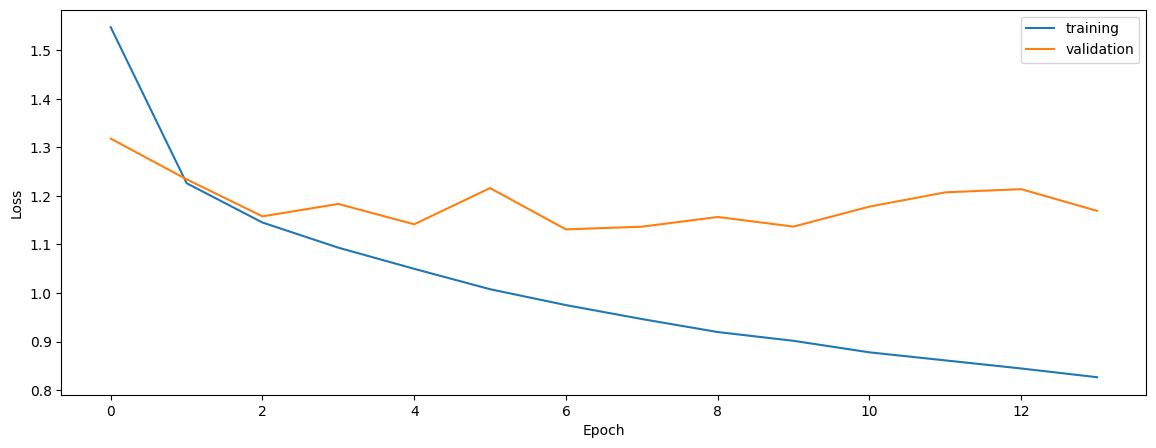

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6296423011195261
0.5435677298021434
0.609367198801736


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized
0.5833056447096369
0.5377250636116574
0.5274667556053791


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native


0.5802746100731985
0.5493012035123979
0.5282280028274878


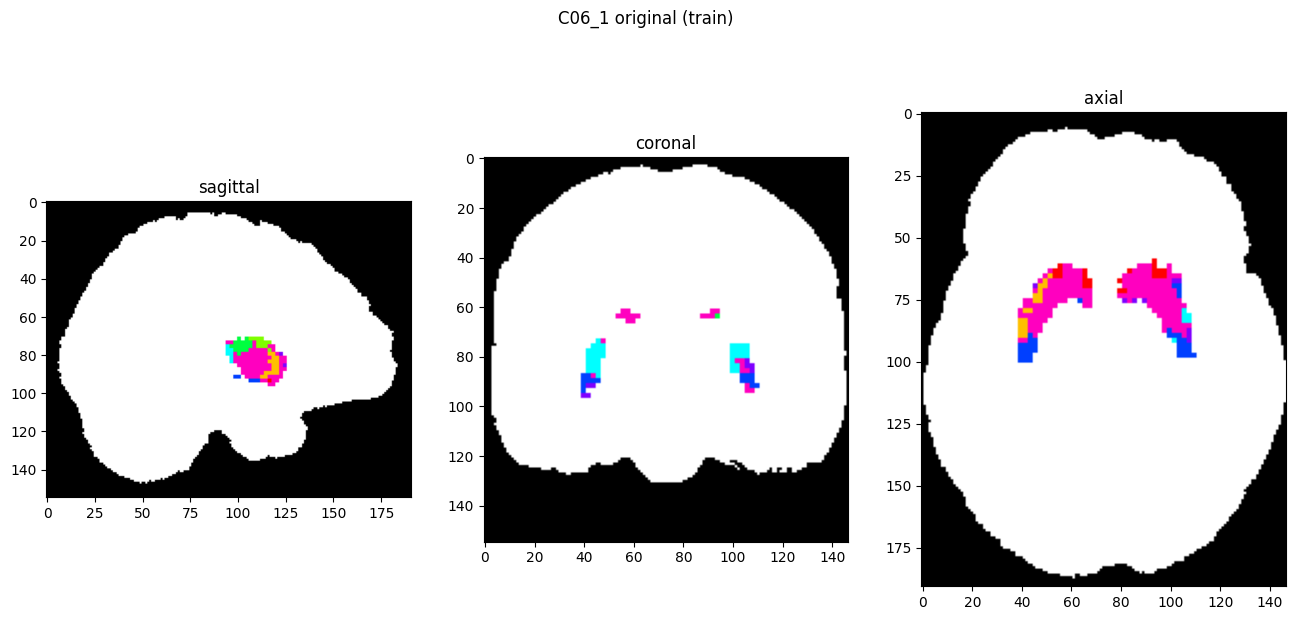

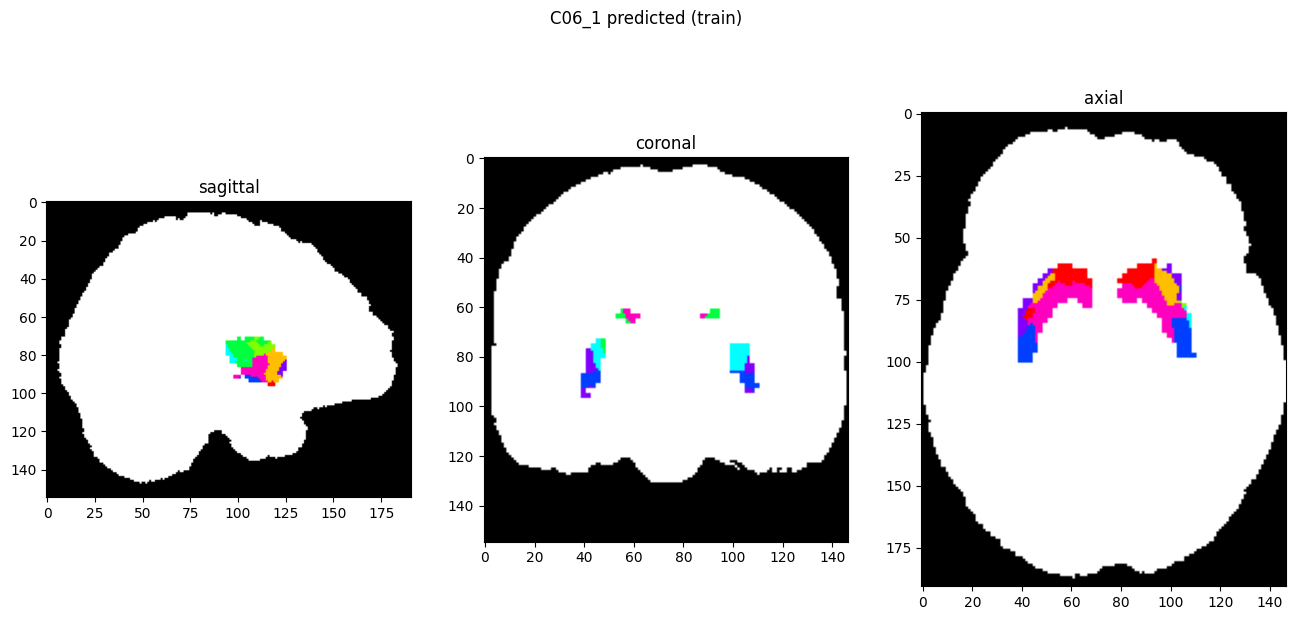

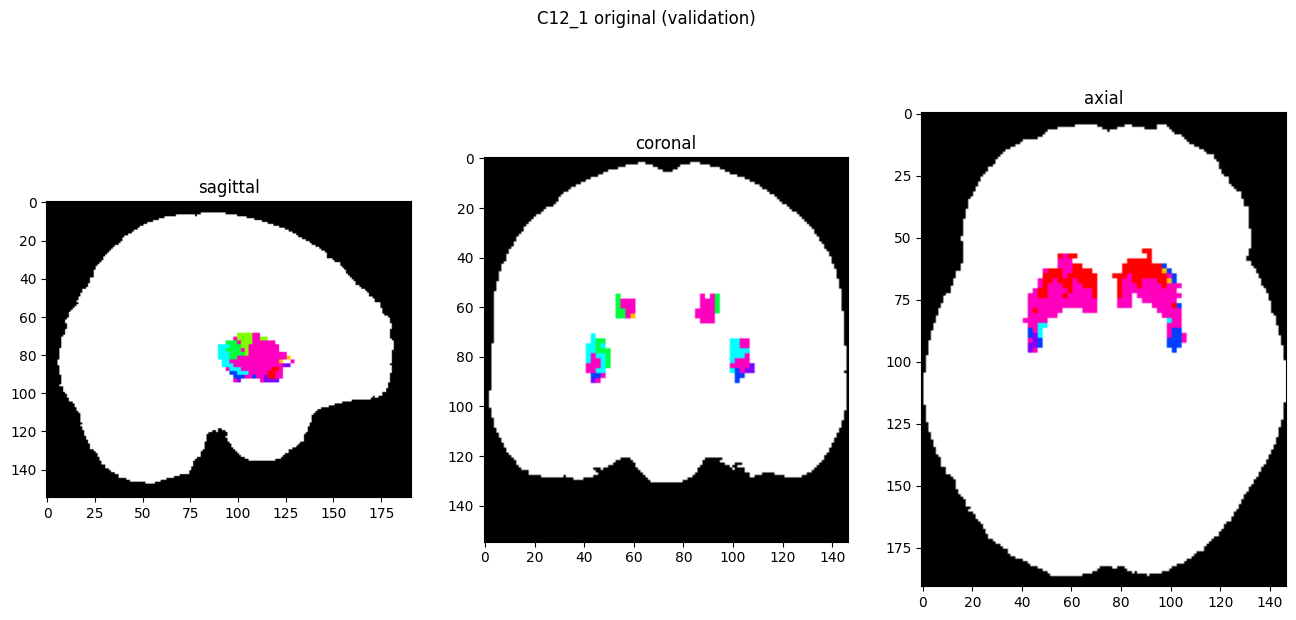

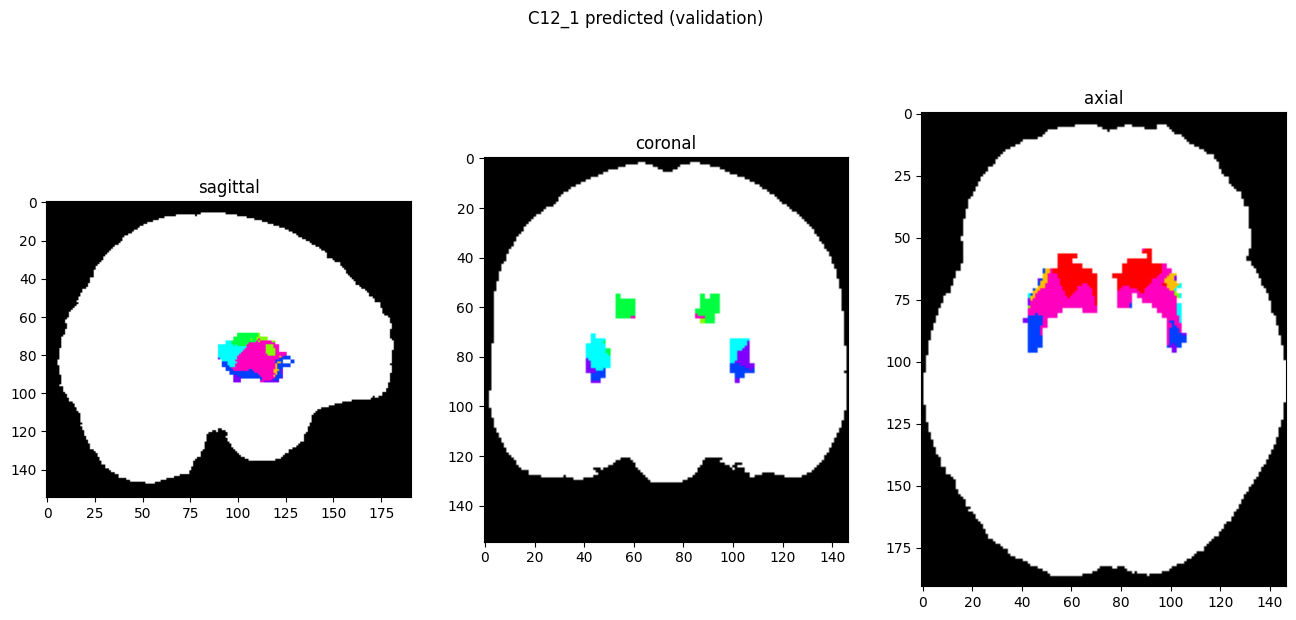

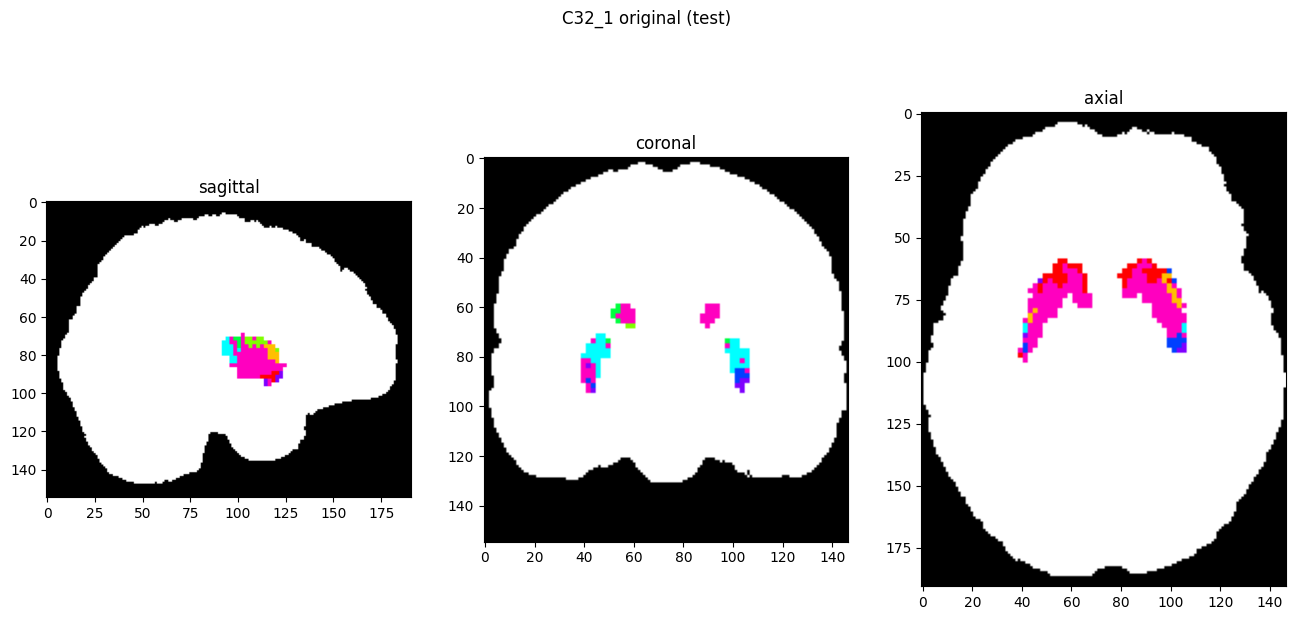

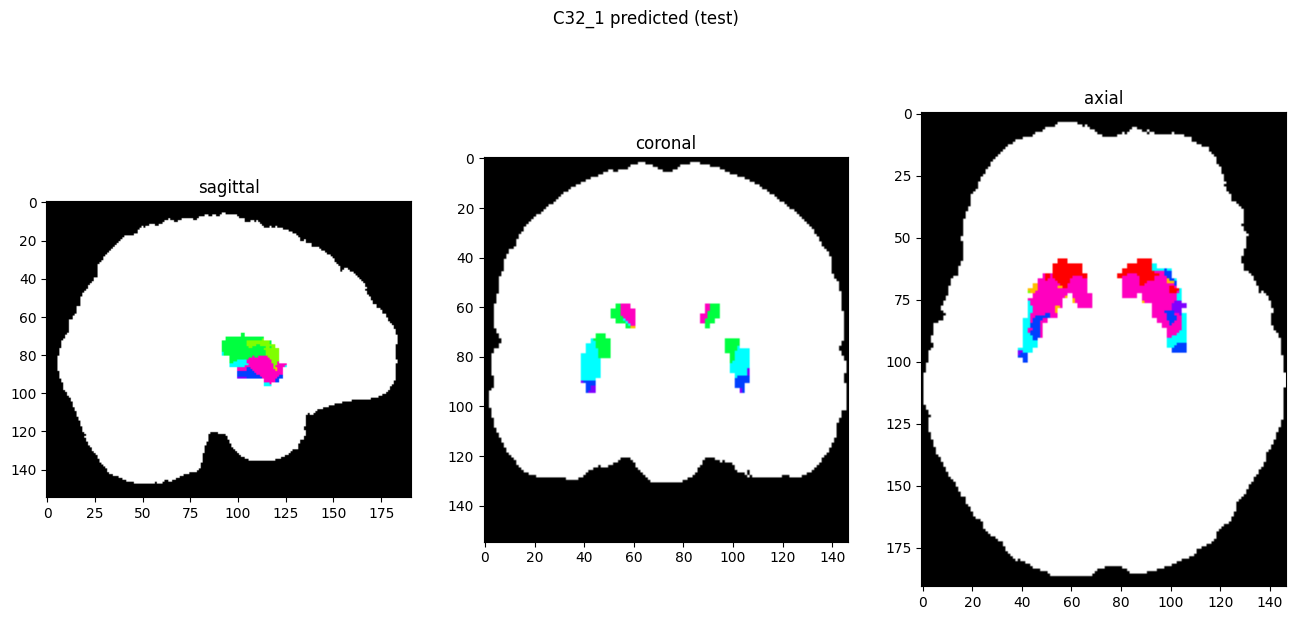

In [10]:
showResults(model, gen, threshold=0)